# CNN ARCHITECTURES


This Notebook presents a practical application of Convolutional Neural Networks (CNNs) for binary image classification tasks, specifically distinguishing between images of chihuahuas and muffins.<br> 
Six different CNN architectures were developed and compared,these varies in complexity, from baseline models to an all-convolution network. Various regularization techniques, specifically Dropout layers and Batch Normalization, were employed to try preventing overfitting and improve model performance.The most promising architecture, in terms of low overfitting, underwent hyperparameter fine-tuning and a 5-fold cross-validation risk estimate. <br>
<br>

The code is structured like this: <br>

**Note: Sections with an asterisk * are trials that did not make it to the final report**

- Uploading of the dataset
- Hhelper function (plots etc.)
- Preprocessing of the image data (reshape, rescale, grayscale)
- test/train set split
- validation/train set split
- early stop definition
- Baseline model
- Baseline model 2.0
- *demo first architecture* *
- First architecture
- *demo second architecture* *
- Second architecrture
- Third architecture
- *demo third architecture* *
- *demo fourth architecture* *
- Fourth architecture
- Fifth architecture
- *hyperparameters tuning 5th architecture* *
- *cross validation 5th architecture* *
- Final architecture
- *hyperparameters tuning Final arch. (hp also kernel size)* *
- *test tuned final arch. 1st and 4th best hp (hp also kernel size)* *
- Hyperparameters tuning Final architecture (kernel_size =3)
- CV tuned Final architecture
- Final architecture: predictin on test set 
- Final architecture: classification report and confusion matrix


In [1]:
# LIBABRY IMPORT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import glob
import os
from PIL import Image

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss, roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, StratifiedKFold

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from keras_tuner import HyperModel, Hyperband, RandomSearch, Objective, HyperParameters, BayesianOptimization
from sklearn.metrics import classification_report

To run the following code, please set up a directory with the current notebook and the dataset folder.

In [2]:
# DATA ACQUISITION
train_dir = './Dataset/train'
test_dir = './Dataset/test'

train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

random.shuffle(train_files)
random.shuffle(test_files)

print("Train images:")
print(train_files)

print("\nTest images:")
print(test_files)

Train images:
['chihuahua', 'muffin']

Test images:
['muffin', 'chihuahua']


HELPER FUNCTIONS

In [92]:
# plot results function
def plot_result(prev_models):
  result = prev_models.history
  epochs = range(len(result["accuracy"]))

  img_accuracy = plt.figure()
  plt.plot(epochs, result["accuracy"], label="Training")
  plt.plot(epochs, result["val_accuracy"], label="Validation")
  plt.title("Accuracy")
  plt.legend()

  img_loss = plt.figure()
  plt.plot(epochs, result['loss'], label="Training")
  plt.plot(epochs, result['val_loss'], label="Validation")
  plt.title("Loss")
  plt.legend()

  return img_accuracy, img_loss

# save plots function
def save_plots_as_jpeg(plots, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for i, plot in enumerate(plots):
        plot.savefig(f"{save_dir}/plot_{i+1}.jpeg")

save_directory = "plots"

# zero-one loss
def zero_one_loss(y_true, y_pred):
    y_pred = tf.round(y_pred)
    loss = tf.cast(tf.not_equal(y_true, y_pred), dtype=tf.float32)
    return tf.reduce_mean(loss)

# Plots for Cross-validation
def plot_accuracy(histories):
    colors = ['b', 'g', 'r', 'm', 'y']
    plt.figure(figsize=(10, 6))

    for i, history in enumerate(histories):
        plt.plot(history.history['accuracy'], color=colors[i], linestyle='-')
        plt.plot(history.history['val_accuracy'], color=colors[i], linestyle='--')

    plt.title('Cross-Valdation 5-fold Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def plot_loss(histories):
    colors = ['b', 'g', 'r', 'm', 'y']
    plt.figure(figsize=(10, 6))

    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], color=colors[i], linestyle='-')
        plt.plot(history.history['val_loss'], color=colors[i], linestyle='--')

    plt.title('Cross-Valdation 5-fold Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def plot_avg_loss(histories):
    avg_train_loss = []
    avg_val_loss = []

    for history in histories:
        avg_train_loss.append(history.history['loss'])
        avg_val_loss.append(history.history['val_loss'])

    avg_train_loss = np.mean(avg_train_loss, axis=0)
    avg_val_loss = np.mean(avg_val_loss, axis=0)
    plt.figure(figsize=(10, 6))

    plt.plot(avg_train_loss, color='blue', linestyle='-')
    plt.plot(avg_val_loss, color='blue', linestyle='--')

    plt.title('Average CV 5-fold Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def plot_avg_accuracy(histories):
    avg_train_acc = []
    avg_val_acc = []

    for history in histories:
        avg_train_acc.append(history.history['accuracy'])
        avg_val_acc.append(history.history['val_accuracy'])

    avg_train_acc = np.mean(avg_train_acc, axis=0)
    avg_val_acc = np.mean(avg_val_acc, axis=0)

    plt.figure(figsize=(10, 6))

    plt.plot(avg_train_acc, color='blue', linestyle='-')
    plt.plot(avg_val_acc, color='blue', linestyle='--')

    plt.title('Average CV 5-fold Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


In [165]:
# Plots CV zero-one loss
def plot_zero_one_loss(histories):
    colors = ['b', 'g', 'r', 'm', 'y']
    plt.figure(figsize=(10, 6))

    for i, history in enumerate(histories):
        plt.plot(history.history['zero_one_loss'], color=colors[i], linestyle='-')
        plt.plot(history.history['val_zero_one_loss'], color=colors[i], linestyle='--')

    plt.title('Cross-Validation 5-fold Zero-One Loss')
    plt.ylabel('Zero-One Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def plot_avg_zero_one_loss(histories):
    avg_train_loss = []
    avg_val_loss = []

    for history in histories:
        avg_train_loss.append(history.history['zero_one_loss'])
        avg_val_loss.append(history.history['val_zero_one_loss'])

    avg_train_loss = np.mean(avg_train_loss, axis=0)
    avg_val_loss = np.mean(avg_val_loss, axis=0)
    plt.figure(figsize=(10, 6))

    plt.plot(avg_train_loss, color='blue', linestyle='-')
    plt.plot(avg_val_loss, color='blue', linestyle='--')

    plt.title('Average CV 5-fold Zero-One Loss')
    plt.ylabel('Zero-One Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


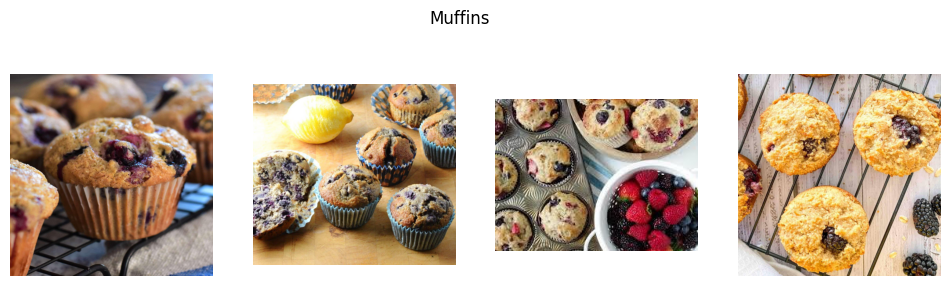

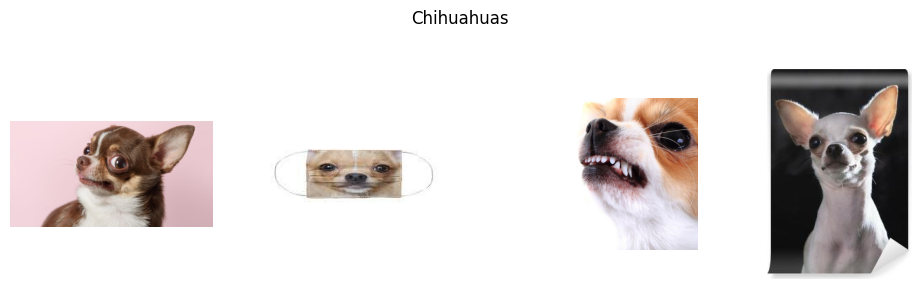

In [4]:
# visualize data
muffin = glob.glob(train_dir + "/muffin/*.jpg")
dog = glob.glob(train_dir + "/chihuahua/*.jpg")

if len(muffin) >= 4 & len(dog) >= 4:
    muffin = random.sample(muffin, 4)
    dog = random.sample(dog, 4)

    plt.figure(figsize=(12, 6))
    for i, path in enumerate(muffin):
        img = mpimg.imread(path)
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle('Muffins')
    plt.show()

    plt.figure(figsize=(12, 6))
    for i, path in enumerate(dog):
        img = mpimg.imread(path)
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle('Chihuahuas')
    plt.show()

### DATA PREPROCESSING

Found 4733 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.
(64, 64, 1)


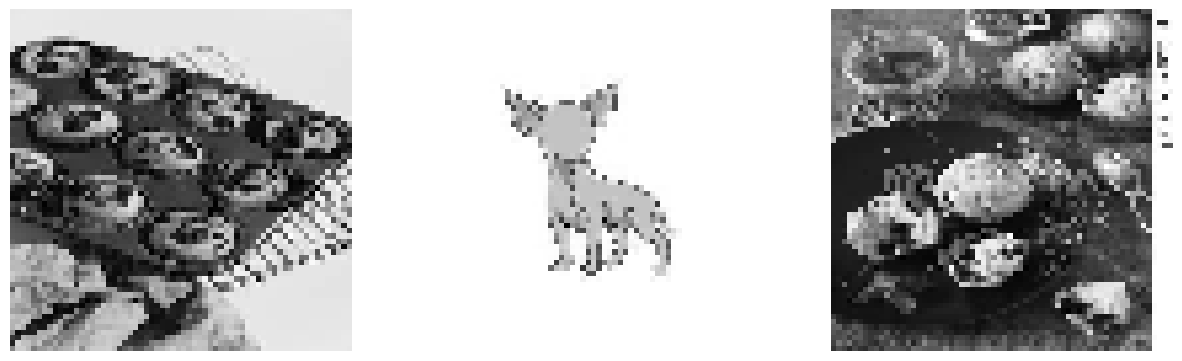

In [5]:
from keras.preprocessing.image import ImageDataGenerator

img_size = (64, 64)
batches_size = 32

scale = ImageDataGenerator(rescale=1./255)

training_set = scale.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batches_size,
    color_mode="grayscale",
    class_mode='binary',
    shuffle=True
)

test_set = scale.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batches_size,
    color_mode="grayscale",
    class_mode='binary',
    shuffle=True
)


images, labels = next(training_set)
image_shape = images[0].shape

print(image_shape)


images, labels = next(training_set)
# Display three random images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    random_index = np.random.randint(0, len(images))
    ax[i].imshow(images[random_index], cmap='gray')
    ax[i].axis('off')

plt.show()

TRAINING SET SPLIT

In [6]:
X_train = []
y_train = []
for i in range(len(training_set)):
    batchX, batchY = training_set.next()
    X_train.extend(batchX)
    y_train.extend(batchY)

X_test = []
y_test = []
for i in range(len(test_set)):
    batchX, batchY = test_set.next()
    X_test.extend(batchX)
    y_test.extend(batchY)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [7]:
print(f'\tSize\n\nTrain set: {X_train.shape}\nTrain lables: {y_train.shape}\nTest set: {X_test.shape}\nTest lables: {y_test.shape}')

	Size

Train set: (4733, 64, 64, 1)
Train lables: (4733,)
Test set: (1184, 64, 64, 1)
Test lables: (1184,)


VALIDATION SET SPLIT

In [8]:
X_train_, X_validation, y_train_, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [9]:
print(f'\tSize\n\nTrain set: {X_train_.shape}\nTrain lables: {y_train_.shape}\nValidation set: {X_validation.shape}\nValidation lables: {y_validation.shape}')

	Size

Train set: (3786, 64, 64, 1)
Train lables: (3786,)
Validation set: (947, 64, 64, 1)
Validation lables: (947,)


EARLY STOP

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## BASELINE MODEL

In [15]:
cnn_base = Sequential() # initialize model

# Convolution layer
cnn_base.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, padding = 'valid', activation='relu'))
cnn_base.add(MaxPool2D(pool_size=(2, 2)))

# Dense layer
cnn_base.add(Flatten())
cnn_base.add(Dense(1, activation='sigmoid'))

cnn_base.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

cnn_base.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 30752)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 30753     
                                                                 
Total params: 31,073
Trainable params: 31,073
Non-trainable params: 0
_________________________________________________________________


In [16]:
# train
prev_models = cnn_base.fit(
    X_train_, y_train_,
    validation_data = (X_validation, y_validation),
    epochs = 20,
    batch_size = 32,
    callbacks = early_stopping
    )

Epoch 1/20
119/119 [==============================] - 8s 61ms/step - loss: 0.5944 - accuracy: 0.6838 - precision_1: 0.6606 - recall_1: 0.6304 - val_loss: 0.5148 - val_accuracy: 0.7719 - val_precision_1: 0.7427 - val_recall_1: 0.7956
Epoch 2/20
119/119 [==============================] - 6s 55ms/step - loss: 0.4708 - accuracy: 0.7887 - precision_1: 0.7796 - recall_1: 0.7480 - val_loss: 0.4707 - val_accuracy: 0.8025 - val_precision_1: 0.7903 - val_recall_1: 0.7956
Epoch 3/20
119/119 [==============================] - 6s 52ms/step - loss: 0.4364 - accuracy: 0.8082 - precision_1: 0.8056 - recall_1: 0.7636 - val_loss: 0.4653 - val_accuracy: 0.7951 - val_precision_1: 0.7591 - val_recall_1: 0.8333
Epoch 4/20
119/119 [==============================] - 7s 58ms/step - loss: 0.4114 - accuracy: 0.8135 - precision_1: 0.8102 - recall_1: 0.7717 - val_loss: 0.4618 - val_accuracy: 0.7867 - val_precision_1: 0.8523 - val_recall_1: 0.6667
Epoch 5/20
119/119 [==============================] - 7s 55ms/step -

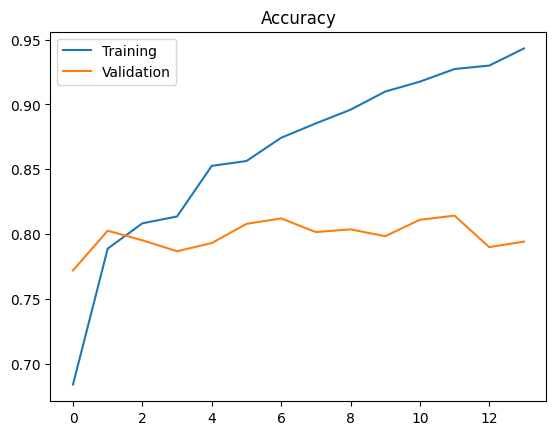

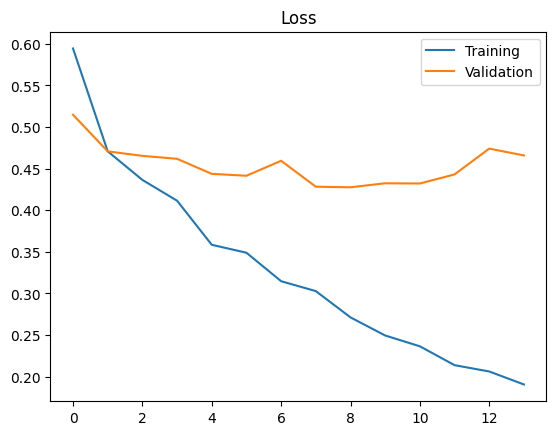

In [62]:
img_accuracy, img_loss = plot_result(prev_models)

In [64]:
# save_plots_as_jpeg([img_accuracy, img_loss], save_directory)

## BASELINE 2.0

In [18]:
cnn_base = Sequential() 

# Convolution layer
cnn_base.add(Conv2D(32, kernel_size=(3, 3), padding = 'valid', input_shape=image_shape, activation='relu'))
cnn_base.add(MaxPool2D(pool_size=(2, 2)))

# Dense layer
cnn_base.add(Flatten())
cnn_base.add(Dense(64, activation = 'relu'))
cnn_base.add(Dense(1, activation='sigmoid'))

cnn_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

cnn_base.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 30752)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1968192   
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,968,577
Trainable params: 1,968,577
Non-trainable params: 0
____________________________________________

In [19]:
model0 = cnn_base.fit(
    X_train_, y_train_,
    validation_data = (X_validation, y_validation),
    epochs = 20,
    batch_size = 32,
    callbacks = early_stopping
    )

Epoch 1/20
119/119 [==============================] - 12s 91ms/step - loss: 0.6204 - accuracy: 0.6569 - precision_2: 0.6315 - recall_2: 0.5939 - val_loss: 0.5609 - val_accuracy: 0.7233 - val_precision_2: 0.6958 - val_recall_2: 0.7422
Epoch 2/20
119/119 [==============================] - 12s 100ms/step - loss: 0.5331 - accuracy: 0.7480 - precision_2: 0.7239 - recall_2: 0.7231 - val_loss: 0.5325 - val_accuracy: 0.7413 - val_precision_2: 0.8213 - val_recall_2: 0.5822
Epoch 3/20
119/119 [==============================] - 10s 87ms/step - loss: 0.4855 - accuracy: 0.7781 - precision_2: 0.7618 - recall_2: 0.7468 - val_loss: 0.5576 - val_accuracy: 0.7191 - val_precision_2: 0.6415 - val_recall_2: 0.9267
Epoch 4/20
119/119 [==============================] - 11s 90ms/step - loss: 0.4630 - accuracy: 0.7868 - precision_2: 0.7711 - recall_2: 0.7572 - val_loss: 0.4844 - val_accuracy: 0.7645 - val_precision_2: 0.8179 - val_recall_2: 0.6489
Epoch 5/20
119/119 [==============================] - 12s 98ms/

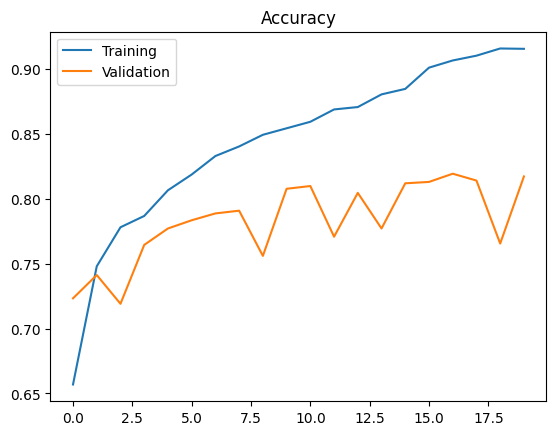

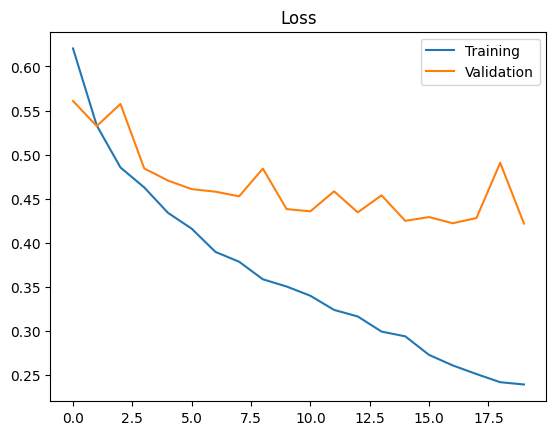

In [65]:
img_accuracy, img_loss = plot_result(model0)

In [66]:
# save_plots_as_jpeg([img_accuracy, img_loss], save_directory)

## Demo First Architecture *

In [21]:
cnn_m1 = Sequential()

# Convolution layers
cnn_m1.add(Conv2D(32, kernel_size=(5, 5), padding = 'valid', input_shape=image_shape, activation='relu'))
cnn_m1.add(MaxPool2D(pool_size=(2, 2)))
cnn_m1.add(Dropout(0.25))
cnn_m1.add(Conv2D(64, kernel_size=(5, 5), padding = 'valid', activation='relu'))
cnn_m1.add(MaxPool2D(pool_size=(2, 2)))

# Dense layers
cnn_m1.add(Flatten())
cnn_m1.add(Dense(128, activation='relu'))
cnn_m1.add(Dropout(0.5))
cnn_m1.add(Dense(1, activation='sigmoid'))

cnn_m1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

cnn_m1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 60, 60, 32)        832       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 64)        51264     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 10816)            

In [22]:
model1 = cnn_m1.fit(
    X_train_, y_train_,
    validation_data = (X_validation, y_validation),
    epochs = 20,
    batch_size = 32,
    callbacks = early_stopping
    )

Epoch 1/20
119/119 [==============================] - 27s 222ms/step - loss: 0.6796 - accuracy: 0.5700 - precision_3: 0.5394 - recall_3: 0.3888 - val_loss: 0.6541 - val_accuracy: 0.6874 - val_precision_3: 0.7319 - val_recall_3: 0.5400
Epoch 2/20
119/119 [==============================] - 25s 206ms/step - loss: 0.6197 - accuracy: 0.6609 - precision_3: 0.6353 - recall_3: 0.6014 - val_loss: 0.6012 - val_accuracy: 0.7381 - val_precision_3: 0.7215 - val_recall_3: 0.7311
Epoch 3/20
119/119 [==============================] - 26s 218ms/step - loss: 0.5435 - accuracy: 0.7406 - precision_3: 0.7158 - recall_3: 0.7149 - val_loss: 0.5403 - val_accuracy: 0.7645 - val_precision_3: 0.7539 - val_recall_3: 0.7489
Epoch 4/20
119/119 [==============================] - 26s 221ms/step - loss: 0.4967 - accuracy: 0.7691 - precision_3: 0.7448 - recall_3: 0.7509 - val_loss: 0.5244 - val_accuracy: 0.7550 - val_precision_3: 0.6968 - val_recall_3: 0.8578
Epoch 5/20
119/119 [==============================] - 26s 21

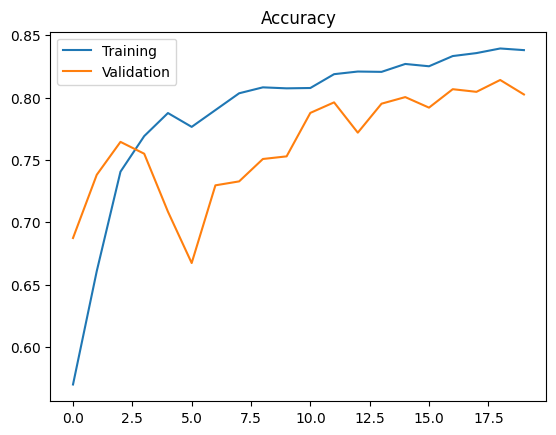

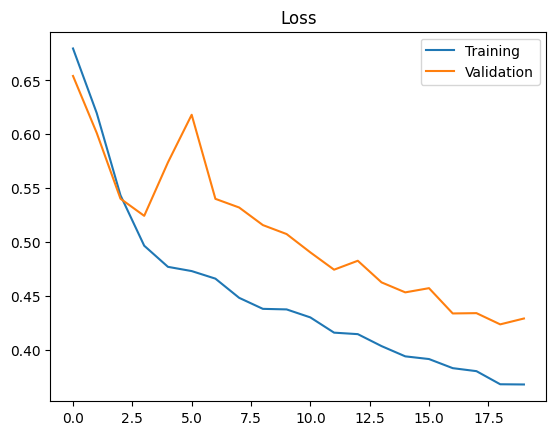

In [23]:
img_accuracy, img_loss = plot_result(model1)

## FIRST ARCHITECTURE

In [24]:
cnn_m1_2 = Sequential() 

# Convolution layers
cnn_m1_2.add(Conv2D(64, kernel_size=(3, 3), padding = 'valid', input_shape=image_shape, activation='relu'))
cnn_m1_2.add(MaxPool2D(pool_size=(2, 2)))
cnn_m1_2.add(Dropout(0.25))

cnn_m1_2.add(Conv2D(96, kernel_size=(5, 5), strides=2, padding = 'valid', activation='relu'))
cnn_m1_2.add(MaxPool2D(pool_size=(2, 2)))
cnn_m1_2.add(Dropout(0.25))


# Dense layers
cnn_m1_2.add(Flatten())
cnn_m1_2.add(Dense(128, activation='relu'))
cnn_m1_2.add(Dropout(0.5))
cnn_m1_2.add(Dense(1, activation='sigmoid'))

cnn_m1_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

cnn_m1_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 31, 31, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 96)        153696    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 7, 96)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 96)         

In [25]:
model1_2 = cnn_m1_2.fit(
    X_train_, y_train_,
    validation_data = (X_validation, y_validation),
    epochs = 20,
    batch_size = 32,
    callbacks = early_stopping
    )

Epoch 1/20
119/119 [==============================] - 27s 213ms/step - loss: 0.6836 - accuracy: 0.5597 - precision_4: 0.5371 - recall_4: 0.2474 - val_loss: 0.6693 - val_accuracy: 0.6251 - val_precision_4: 0.5661 - val_recall_4: 0.9044
Epoch 2/20
119/119 [==============================] - 25s 207ms/step - loss: 0.6275 - accuracy: 0.6461 - precision_4: 0.6255 - recall_4: 0.5574 - val_loss: 0.5947 - val_accuracy: 0.6906 - val_precision_4: 0.6315 - val_recall_4: 0.8378
Epoch 3/20
119/119 [==============================] - 25s 212ms/step - loss: 0.5585 - accuracy: 0.7285 - precision_4: 0.7010 - recall_4: 0.7051 - val_loss: 0.5821 - val_accuracy: 0.6948 - val_precision_4: 0.6214 - val_recall_4: 0.9156
Epoch 4/20
119/119 [==============================] - 25s 208ms/step - loss: 0.5148 - accuracy: 0.7639 - precision_4: 0.7430 - recall_4: 0.7370 - val_loss: 0.5118 - val_accuracy: 0.7656 - val_precision_4: 0.7218 - val_recall_4: 0.8244
Epoch 5/20
119/119 [==============================] - 24s 19

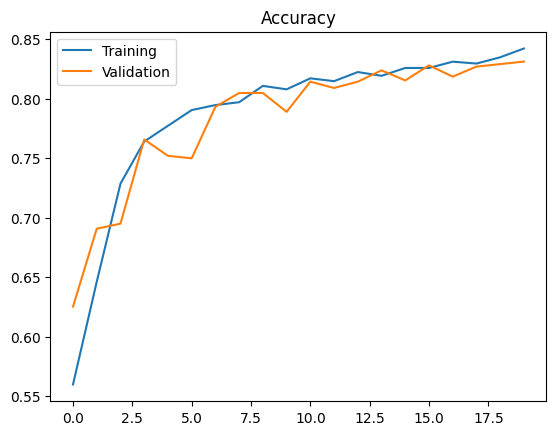

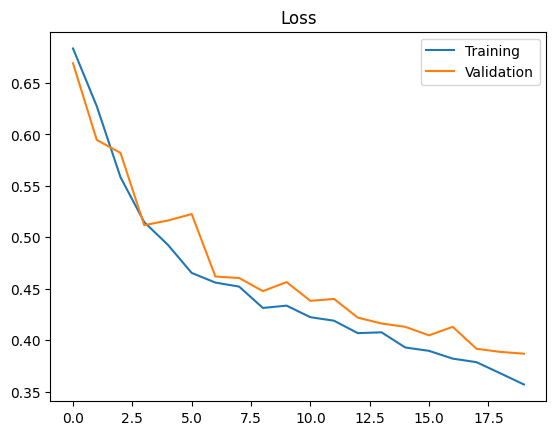

In [67]:
img_accuracy, img_loss = plot_result(model1_2)

In [68]:
# save_plots_as_jpeg([img_accuracy, img_loss], save_directory)

## Demo Second Architecture *

Several Dense layers

In [27]:
cnn_m2 = Sequential()

# Convolution layers
cnn_m2.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
cnn_m2.add(MaxPool2D(pool_size=(2, 2)))
cnn_m2.add(Dropout(0.2))
cnn_m2.add(Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding = 'valid', activation='relu'))
cnn_m2.add(MaxPool2D(pool_size=(2, 2)))
cnn_m2.add(Conv2D(filters=64, kernel_size=(5, 5), strides=2, padding = 'valid', activation='relu'))

# Dense layers
cnn_m2.add(Flatten())
cnn_m2.add(Dense(256, activation='relu'))
cnn_m2.add(Dropout(0.5))
cnn_m2.add(Dense(128, activation='relu'))
cnn_m2.add(Dropout(0.3))
cnn_m2.add(Dense(64, activation='relu'))
cnn_m2.add(Dropout(0.1))
cnn_m2.add(Dense(1, activation='sigmoid'))

cnn_m2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

cnn_m2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 62, 62, 16)        160       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 31, 31, 16)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        12832     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 2, 64)         

In [28]:
model2 = cnn_m2.fit(
    X_train_, y_train_,
    validation_data = (X_validation, y_validation),
    epochs = 20,
    batch_size = 32,
    callbacks = early_stopping
    )

Epoch 1/20
119/119 [==============================] - 9s 62ms/step - loss: 0.6907 - accuracy: 0.5383 - precision_5: 0.4665 - recall_5: 0.0886 - val_loss: 0.6902 - val_accuracy: 0.5248 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/20
119/119 [==============================] - 7s 55ms/step - loss: 0.6747 - accuracy: 0.5716 - precision_5: 0.6461 - recall_5: 0.1333 - val_loss: 0.6417 - val_accuracy: 0.6959 - val_precision_5: 0.6995 - val_recall_5: 0.6311
Epoch 3/20
119/119 [==============================] - 6s 54ms/step - loss: 0.6096 - accuracy: 0.6709 - precision_5: 0.6387 - recall_5: 0.6402 - val_loss: 0.6104 - val_accuracy: 0.6484 - val_precision_5: 0.5814 - val_recall_5: 0.9289
Epoch 4/20
119/119 [==============================] - 6s 53ms/step - loss: 0.5526 - accuracy: 0.7287 - precision_5: 0.6900 - recall_5: 0.7352 - val_loss: 0.5798 - val_accuracy: 0.6927 - val_precision_5: 0.6164 - val_recall_5: 0.9356
Epoch 5/20
119/119 [==============================] - 7s 60m

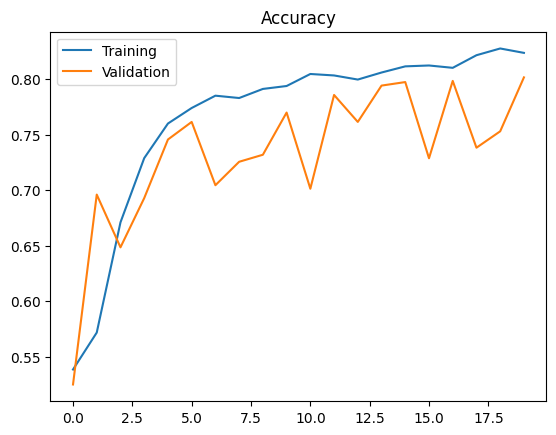

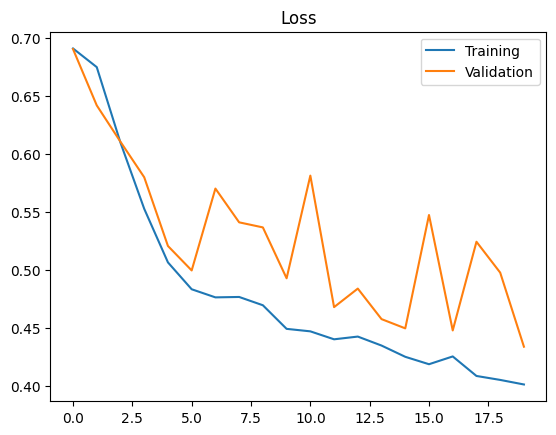

In [29]:
img_accuracy, img_loss = plot_result(model2)

## SECOND ARCHITECTURE

In [30]:
cnn_m2_2 = Sequential() 

# Convolution layers
cnn_m2_2.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
cnn_m2_2.add(MaxPool2D(pool_size=(2, 2)))
cnn_m2_2.add(Dropout(0.2))
cnn_m2_2.add(Conv2D(filters=96, kernel_size=(5, 5), strides=2, padding = 'valid', activation='relu'))
cnn_m2_2.add(MaxPool2D(pool_size=(2, 2)))
cnn_m2_2.add(Dropout(0.2))

# Dense layers
cnn_m2_2.add(Flatten())
cnn_m2_2.add(Dense(256, activation='relu'))
cnn_m2_2.add(Dropout(0.5))
cnn_m2_2.add(Dense(128, activation='relu'))
cnn_m2_2.add(Dropout(0.3))
cnn_m2_2.add(Dense(64, activation='relu'))
cnn_m2_2.add(Dropout(0.1))
cnn_m2_2.add(Dense(1, activation='sigmoid'))

cnn_m2_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

cnn_m2_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 31, 31, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 96)        153696    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 7, 7, 96)         0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 7, 7, 96)         

In [31]:
model2_2 = cnn_m2_2.fit(
    X_train_, y_train_,
    validation_data = (X_validation, y_validation),
    epochs = 20,
    batch_size = 32,
    callbacks = early_stopping
    )

Epoch 1/20
119/119 [==============================] - 29s 233ms/step - loss: 0.6892 - accuracy: 0.5415 - precision_6: 0.4867 - recall_6: 0.1060 - val_loss: 0.6851 - val_accuracy: 0.5238 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/20
119/119 [==============================] - 26s 217ms/step - loss: 0.6655 - accuracy: 0.5880 - precision_6: 0.5961 - recall_6: 0.2984 - val_loss: 0.6262 - val_accuracy: 0.6579 - val_precision_6: 0.6061 - val_recall_6: 0.8000
Epoch 3/20
119/119 [==============================] - 28s 231ms/step - loss: 0.5852 - accuracy: 0.7013 - precision_6: 0.6699 - recall_6: 0.6796 - val_loss: 0.5766 - val_accuracy: 0.6895 - val_precision_6: 0.6211 - val_recall_6: 0.8889
Epoch 4/20
119/119 [==============================] - 28s 234ms/step - loss: 0.5276 - accuracy: 0.7528 - precision_6: 0.7265 - recall_6: 0.7341 - val_loss: 0.5217 - val_accuracy: 0.7603 - val_precision_6: 0.7002 - val_recall_6: 0.8667
Epoch 5/20
119/119 [==============================] 

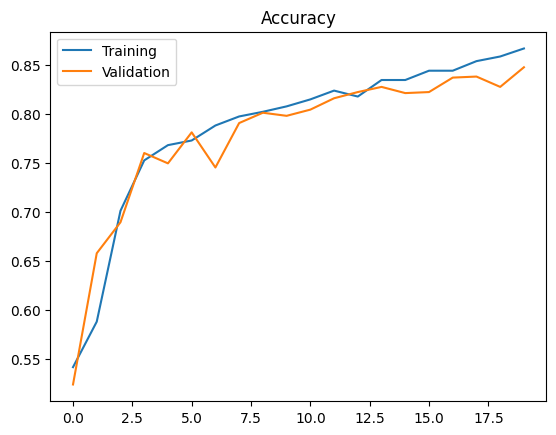

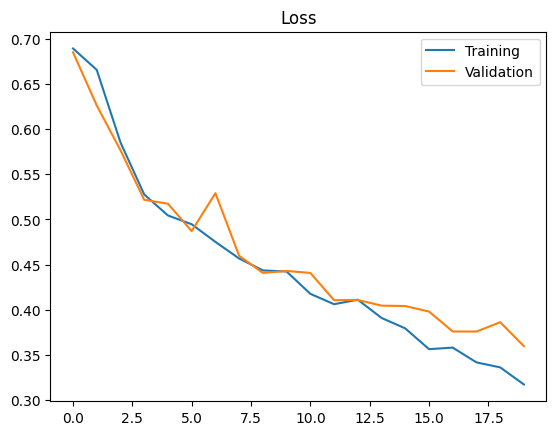

In [69]:
img_accuracy, img_loss = plot_result(model2_2)

In [70]:
# save_plots_as_jpeg([img_accuracy, img_loss], save_directory)

## THIRD ARCHITECTURE

No pooling, just several Convolutions with stride = 2

In [33]:
cnn_m3 = Sequential() 

# Convolution layers
cnn_m3.add(Conv2D(filters=32, kernel_size=(3, 3), strides=2,input_shape=image_shape))
cnn_m3.add(Activation('relu'))
cnn_m3.add(Dropout(0.2))

cnn_m3.add(Conv2D(filters=48, kernel_size=(3, 3), strides=2, padding = 'valid'))
cnn_m3.add(Activation('relu'))
cnn_m3.add(Dropout(0.2))

cnn_m3.add(Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding = 'valid'))
cnn_m3.add(Activation('relu'))
cnn_m3.add(Dropout(0.2))



# Dense layer
cnn_m3.add(Flatten())
cnn_m3.add(Dense(128))
cnn_m3.add(Activation('relu'))
cnn_m3.add(Dropout(0.5))

cnn_m3.add(Dense(1, activation='sigmoid'))

cnn_m3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

cnn_m3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 31, 31, 32)        320       
                                                                 
 activation (Activation)     (None, 31, 31, 32)        0         
                                                                 
 dropout_14 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 15, 15, 48)        13872     
                                                                 
 activation_1 (Activation)   (None, 15, 15, 48)        0         
                                                                 
 dropout_15 (Dropout)        (None, 15, 15, 48)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 64)         

In [34]:
model3 = cnn_m3.fit(
    X_train_, y_train_,
    validation_data = (X_validation, y_validation),
    epochs = 20,
    batch_size = 32,
    callbacks = early_stopping
    )

Epoch 1/20
119/119 [==============================] - 8s 58ms/step - loss: 0.6875 - accuracy: 0.5401 - precision_7: 0.4819 - recall_7: 0.1159 - val_loss: 0.6853 - val_accuracy: 0.5259 - val_precision_7: 1.0000 - val_recall_7: 0.0022
Epoch 2/20
119/119 [==============================] - 7s 57ms/step - loss: 0.6820 - accuracy: 0.5560 - precision_7: 0.5524 - recall_7: 0.1373 - val_loss: 0.6731 - val_accuracy: 0.5544 - val_precision_7: 0.7121 - val_recall_7: 0.1044
Epoch 3/20
119/119 [==============================] - 7s 58ms/step - loss: 0.6649 - accuracy: 0.5909 - precision_7: 0.6083 - recall_7: 0.2879 - val_loss: 0.6353 - val_accuracy: 0.6325 - val_precision_7: 0.7179 - val_recall_7: 0.3733
Epoch 4/20
119/119 [==============================] - 8s 68ms/step - loss: 0.6233 - accuracy: 0.6437 - precision_7: 0.6083 - recall_7: 0.6136 - val_loss: 0.5923 - val_accuracy: 0.6906 - val_precision_7: 0.7018 - val_recall_7: 0.6067
Epoch 5/20
119/119 [==============================] - 8s 67ms/step -

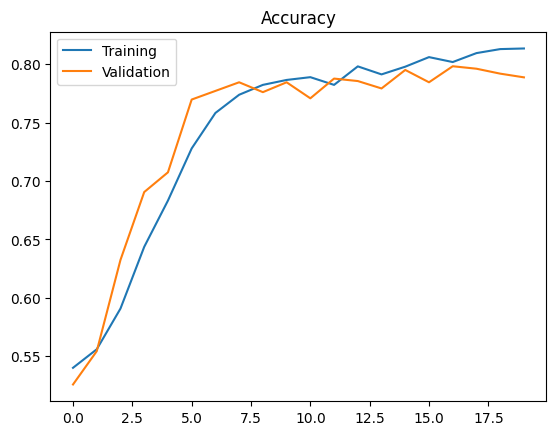

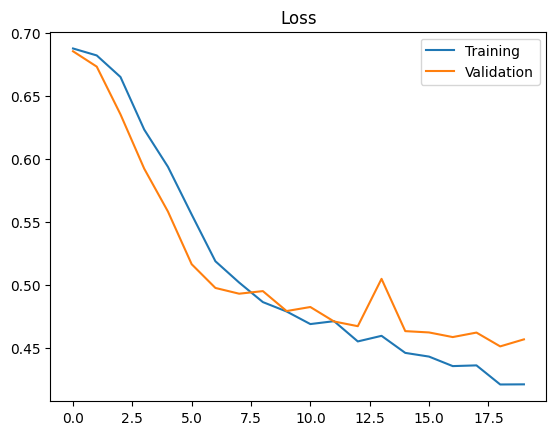

In [71]:
img_accuracy, img_loss = plot_result(model3)

In [72]:
# save_plots_as_jpeg([img_accuracy, img_loss], save_directory)

### Demo Third Architecture * 

In [36]:
cnn_m3_2 = Sequential()

# Convolution layers
cnn_m3_2.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=image_shape))
cnn_m3_2.add(Activation('relu'))
cnn_m3.add(Dropout(0.2))

cnn_m3_2.add(Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding = 'valid'))
cnn_m3_2.add(Activation('relu'))
cnn_m3_2.add(Dropout(0.2))

cnn_m3_2.add(Conv2D(filters=48, kernel_size=(5, 5), strides=2, padding = 'valid'))
cnn_m3_2.add(Activation('relu'))
cnn_m3_2.add(Dropout(0.2))

cnn_m3_2.add(Conv2D(filters=64, kernel_size=(5, 5), strides=2, padding = 'valid'))
cnn_m3_2.add(Activation('relu'))
cnn_m3_2.add(Dropout(0.2))



# Dense layers
cnn_m3_2.add(Flatten())
cnn_m3_2.add(Dense(256))
cnn_m3_2.add(Activation('relu'))
cnn_m3_2.add(Dropout(0.4))

cnn_m3_2.add(Dense(1, activation='sigmoid'))

cnn_m3_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

cnn_m3_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 62, 62, 16)        160       
                                                                 
 activation_4 (Activation)   (None, 62, 62, 16)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        4640      
                                                                 
 activation_5 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 dropout_19 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 13, 13, 48)        38448     
                                                                 
 activation_6 (Activation)   (None, 13, 13, 48)       

In [37]:
model3_2 = cnn_m3_2.fit(
    X_train_, y_train_,
    validation_data = (X_validation, y_validation),
    epochs = 20,
    batch_size = 32,
    callbacks = early_stopping
    )

Epoch 1/20
119/119 [==============================] - 16s 120ms/step - loss: 0.6873 - accuracy: 0.5359 - precision_8: 0.3931 - recall_8: 0.0330 - val_loss: 0.6815 - val_accuracy: 0.5269 - val_precision_8: 1.0000 - val_recall_8: 0.0044
Epoch 2/20
119/119 [==============================] - 14s 120ms/step - loss: 0.6647 - accuracy: 0.5771 - precision_8: 0.5749 - recall_8: 0.2781 - val_loss: 0.6043 - val_accuracy: 0.6948 - val_precision_8: 0.6851 - val_recall_8: 0.6622
Epoch 3/20
119/119 [==============================] - 14s 116ms/step - loss: 0.5830 - accuracy: 0.6960 - precision_8: 0.6550 - recall_8: 0.7039 - val_loss: 0.5344 - val_accuracy: 0.7592 - val_precision_8: 0.7861 - val_recall_8: 0.6778
Epoch 4/20
119/119 [==============================] - 13s 110ms/step - loss: 0.5541 - accuracy: 0.7145 - precision_8: 0.6809 - recall_8: 0.7034 - val_loss: 0.5705 - val_accuracy: 0.7107 - val_precision_8: 0.6350 - val_recall_8: 0.9200
Epoch 5/20
119/119 [==============================] - 13s 10

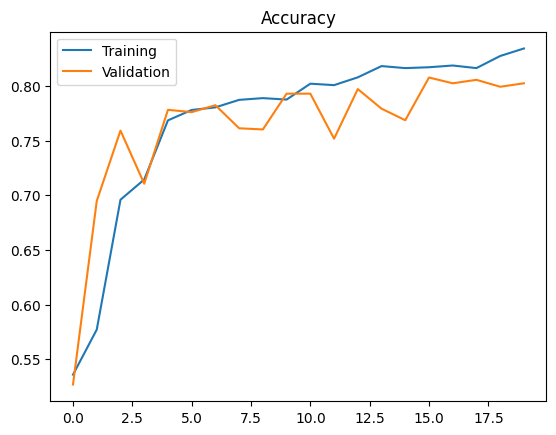

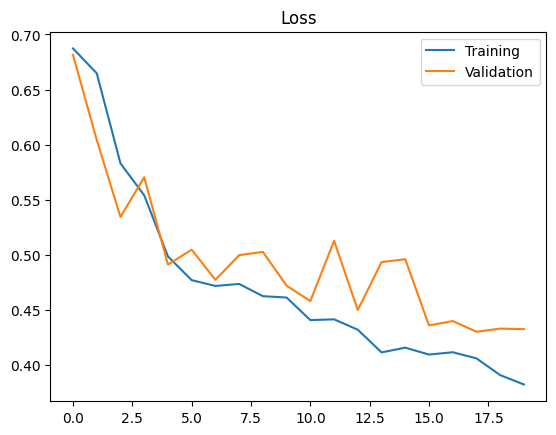

In [38]:
img_accuracy, img_loss = plot_result(model3_2)

## Demo Fourth Architecture * 

Introduce Batch Normalization

In [39]:
from tensorflow.keras.layers import BatchNormalization

cnn_m4 = Sequential()

# Convolution layers
cnn_m4.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=image_shape))
cnn_m4.add(BatchNormalization(center=True, scale=True))
cnn_m4.add(Activation('relu'))
cnn_m4.add(MaxPool2D(pool_size=(2, 2)))

cnn_m4.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding = 'same'))
cnn_m4.add(BatchNormalization(center=True, scale=True))
cnn_m4.add(Activation('relu'))
cnn_m4.add(MaxPool2D(pool_size=(2, 2)))

cnn_m4.add(Conv2D(filters=48, kernel_size=(3, 3), strides=1, padding = 'same'))
cnn_m4.add(BatchNormalization(center=True, scale=True))
cnn_m4.add(Activation('relu'))
cnn_m4.add(MaxPool2D(pool_size=(2, 2)))

cnn_m4.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding = 'same'))
cnn_m4.add(BatchNormalization(center=True, scale=True))
cnn_m4.add(Activation('relu'))
cnn_m4.add(MaxPool2D(pool_size=(2, 2)))



# Dense layers
cnn_m4.add(Flatten())
cnn_m4.add(Dense(256))
cnn_m4.add(BatchNormalization(center=True, scale=True))
cnn_m4.add(Activation('relu'))
cnn_m4.add(Dropout(0.5))


cnn_m4.add(Dense(1, activation='sigmoid'))

cnn_m4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

cnn_m4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 62, 62, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 16)       64        
 ormalization)                                                   
                                                                 
 activation_9 (Activation)   (None, 62, 62, 16)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 31, 31, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 31, 31, 32)      

In [40]:
model4 = cnn_m4.fit(
    X_train_, y_train_,
    validation_data = (X_validation, y_validation),
    epochs = 20,
    batch_size = 32,
    callbacks = early_stopping
    )

Epoch 1/20
119/119 [==============================] - 17s 124ms/step - loss: 0.6393 - accuracy: 0.6830 - precision_9: 0.6527 - recall_9: 0.6512 - val_loss: 1.1394 - val_accuracy: 0.5248 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 2/20
119/119 [==============================] - 15s 120ms/step - loss: 0.4804 - accuracy: 0.7903 - precision_9: 0.7735 - recall_9: 0.7636 - val_loss: 1.5742 - val_accuracy: 0.5248 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 3/20
119/119 [==============================] - 15s 130ms/step - loss: 0.4232 - accuracy: 0.8148 - precision_9: 0.8049 - recall_9: 0.7839 - val_loss: 1.5961 - val_accuracy: 0.5248 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 4/20
119/119 [==============================] - 14s 117ms/step - loss: 0.3862 - accuracy: 0.8275 - precision_9: 0.8207 - recall_9: 0.7955 - val_loss: 1.0620 - val_accuracy: 0.5618 - val_precision_9: 0.9487 - val_recall_9: 0.0822
Epoch 5/20
119/119 [================

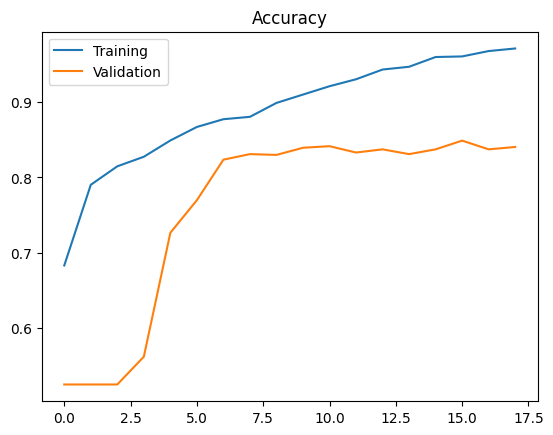

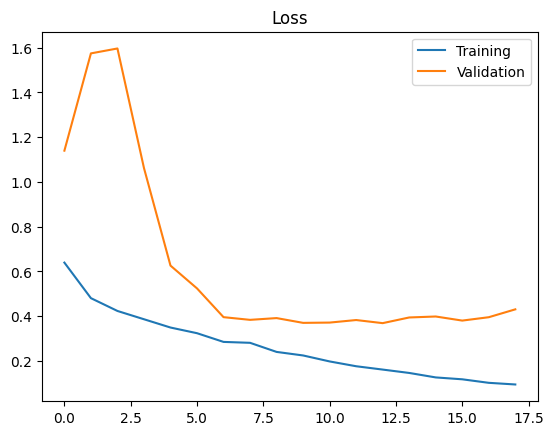

In [41]:
img_accuracy, img_loss = plot_result(model4)

## FOURTH ARCHITECTURE

In [42]:
cnn_m4_2 = Sequential() 

# Convolution layers
cnn_m4_2.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape))
cnn_m4_2.add(BatchNormalization(center=True, scale=True))
cnn_m4_2.add(Activation('relu'))
cnn_m4_2.add(MaxPool2D(pool_size=(2, 2)))

cnn_m4_2.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding = 'valid'))
cnn_m4_2.add(BatchNormalization(center=True, scale=True))
cnn_m4_2.add(Activation('relu'))
cnn_m4_2.add(MaxPool2D(pool_size=(2, 2)))

cnn_m4_2.add(Conv2D(filters=96, kernel_size=(3, 3), strides=1, padding = 'valid'))
cnn_m4_2.add(BatchNormalization(center=True, scale=True))
cnn_m4_2.add(Activation('relu'))
cnn_m4_2.add(MaxPool2D(pool_size=(2, 2)))


# Dense layer
cnn_m4_2.add(Flatten())
cnn_m4_2.add(Dense(256))
cnn_m4_2.add(BatchNormalization(center=True, scale=True))
cnn_m4_2.add(Activation('relu'))
cnn_m4_2.add(Dropout(0.5))


cnn_m4_2.add(Dense(1, activation='sigmoid'))

cnn_m4_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

cnn_m4_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 batch_normalization_5 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_14 (Activation)  (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 29, 29, 64)     

In [43]:
model4_2 = cnn_m4_2.fit(
    X_train_, y_train_,
    validation_data = (X_validation, y_validation),
    epochs = 20,
    batch_size = 32,
    callbacks = early_stopping
    )

Epoch 1/20
119/119 [==============================] - 28s 218ms/step - loss: 0.5507 - accuracy: 0.7441 - precision_10: 0.7246 - recall_10: 0.7074 - val_loss: 1.7080 - val_accuracy: 0.5248 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 2/20
119/119 [==============================] - 26s 216ms/step - loss: 0.4031 - accuracy: 0.8199 - precision_10: 0.8071 - recall_10: 0.7949 - val_loss: 1.9400 - val_accuracy: 0.5248 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 3/20
119/119 [==============================] - 29s 243ms/step - loss: 0.3156 - accuracy: 0.8642 - precision_10: 0.8599 - recall_10: 0.8389 - val_loss: 1.8577 - val_accuracy: 0.5248 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 4/20
119/119 [==============================] - 28s 232ms/step - loss: 0.2774 - accuracy: 0.8833 - precision_10: 0.8737 - recall_10: 0.8696 - val_loss: 1.0579 - val_accuracy: 0.5660 - val_precision_10: 0.9149 - val_recall_10: 0.0956
Epoch 5/20
119/119 [

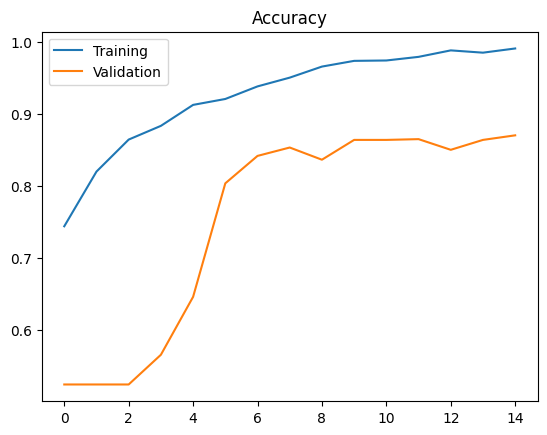

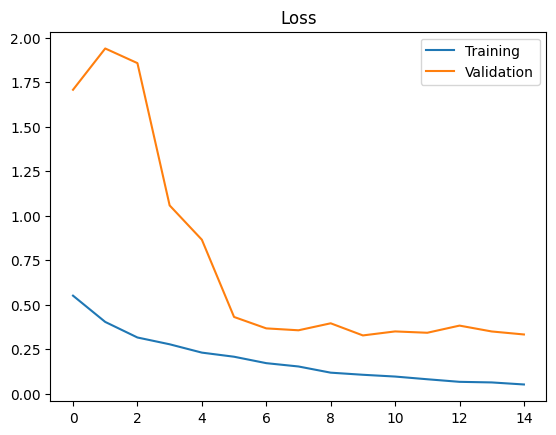

In [73]:
img_accuracy, img_loss = plot_result(model4_2)

In [74]:
# save_plots_as_jpeg([img_accuracy, img_loss], save_directory)

## FIFTH ARCHITECTURE

No pooling, batch normalization, multiple dense

In [86]:
cnn_mf = Sequential()

# Convolution layers
cnn_mf.add(Conv2D(filters=32, kernel_size=(3, 3), strides=2,input_shape=image_shape))
cnn_mf.add(BatchNormalization(center=True, scale=True))
cnn_mf.add(Activation('relu'))

cnn_mf.add(Conv2D(filters=48, kernel_size=(3, 3), strides=2, padding = 'valid'))
cnn_mf.add(BatchNormalization(center=True, scale=True))
cnn_mf.add(Activation('relu'))

cnn_mf.add(Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding = 'valid'))
cnn_mf.add(BatchNormalization(center=True, scale=True))
cnn_mf.add(Activation('relu'))


# Dense layers
cnn_mf.add(Flatten())
cnn_mf.add(Dense(256))
cnn_mf.add(BatchNormalization(center=True, scale=True))
cnn_mf.add(Activation('relu'))

cnn_mf.add(Dense(128))
cnn_mf.add(BatchNormalization(center=True, scale=True))
cnn_mf.add(Activation('relu'))

cnn_mf.add(Dense(64))
cnn_mf.add(BatchNormalization(center=True, scale=True))
cnn_mf.add(Activation('relu'))

cnn_mf.add(Dropout(0.5))

cnn_mf.add(Dense(1, activation='sigmoid'))

cnn_mf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

cnn_mf.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 31, 31, 32)        320       
                                                                 
 batch_normalization_42 (Bat  (None, 31, 31, 32)       128       
 chNormalization)                                                
                                                                 
 activation_62 (Activation)  (None, 31, 31, 32)        0         
                                                                 
 conv2d_54 (Conv2D)          (None, 15, 15, 48)        13872     
                                                                 
 batch_normalization_43 (Bat  (None, 15, 15, 48)       192       
 chNormalization)                                                
                                                                 
 activation_63 (Activation)  (None, 15, 15, 48)      

In [87]:
model_final = cnn_mf.fit(
    X_train_, y_train_,
    validation_data = (X_validation, y_validation),
    epochs = 20,
    batch_size = 32,
    callbacks = early_stopping
    )

Epoch 1/20
119/119 [==============================] - 13s 83ms/step - loss: 0.6815 - accuracy: 0.6257 - precision_20: 0.5922 - recall_20: 0.5747 - val_loss: 0.7967 - val_accuracy: 0.5248 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00
Epoch 2/20
119/119 [==============================] - 10s 86ms/step - loss: 0.4910 - accuracy: 0.7705 - precision_20: 0.7567 - recall_20: 0.7317 - val_loss: 1.2714 - val_accuracy: 0.5248 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00
Epoch 3/20
119/119 [==============================] - 10s 81ms/step - loss: 0.3913 - accuracy: 0.8333 - precision_20: 0.8192 - recall_20: 0.8140 - val_loss: 1.4573 - val_accuracy: 0.5248 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00
Epoch 4/20
119/119 [==============================] - 10s 80ms/step - loss: 0.3263 - accuracy: 0.8650 - precision_20: 0.8584 - recall_20: 0.8430 - val_loss: 1.0600 - val_accuracy: 0.5438 - val_precision_20: 0.8462 - val_recall_20: 0.0489
Epoch 5/20
119/119 [====

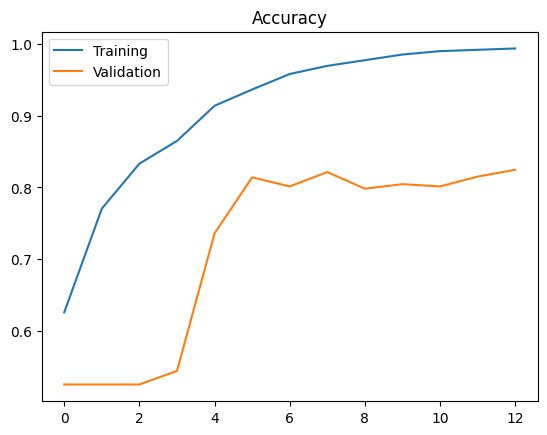

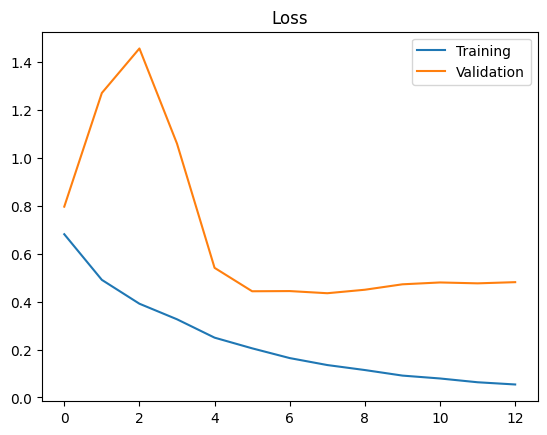

In [89]:
img_accuracy, img_loss = plot_result(model_final)

In [90]:
# save_plots_as_jpeg([img_accuracy, img_loss], save_directory)

### HP tuning 5th architecture *

In [91]:
def hp_tuner(hp):
    image_shape = (64, 64, 1)
    dropout_conv = hp.Float('dropout_conv_layer',
                            min_value = 0.1,
                            max_value = 0.4,
                            step = 0.05)
    dropout_dense = hp.Float('dropout_dense_layer',
                            min_value = 0.2,
                            max_value = 0.5,
                            step = 0.1)

    model = Sequential()

    # Conv 1
    model.add(Conv2D(filters = hp.Int('conv_1_filters',
                                      min_value = 16,
                                      max_value = 64,
                                      step = 16),
                                      kernel_size = hp.Int(
                                          'conv_1_kernel',
                                          min_value = 3,
                                          max_value = 5,
                                          step = 2),
                                      input_shape = image_shape))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_conv))

    # Conv 2
    model.add(Conv2D(filters = hp.Int('conv_2_filters',
                                      min_value = 16,
                                      max_value = 64,
                                      step = 16),
                                      kernel_size = hp.Int(
                                          'conv_2_kernel',
                                          min_value = 3,
                                          max_value = 5,
                                          step = 2),
                                      strides = 2,
                                      padding = 'valid'))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_conv))

    # Conv 3
    model.add(Conv2D(filters = hp.Int('conv_3_filters',
                                      min_value = 16,
                                      max_value = 64,
                                      step = 16),
                                      kernel_size = hp.Int(
                                          'conv_3_kernel',
                                          min_value = 3,
                                          max_value = 5,
                                          step = 2),
                                      strides = 2,
                                      padding = 'valid'))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_conv))

    # Conv 4
    model.add(Conv2D(filters = hp.Int('conv_4_filters',
                                      min_value = 16,
                                      max_value = 64,
                                      step = 16),
                                      kernel_size = hp.Int(
                                          'conv_4_kernel',
                                          min_value = 3,
                                          max_value = 5,
                                          step = 2),
                                      strides = 2,
                                      padding = 'valid'))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_conv))

    # Dense 1
    model.add(Flatten())
    model.add(Dense(units = hp.Int('dense_1_units',
                                   min_value = 32,
                                   max_value = 256,
                                   step = 32)))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_dense))

    # Dense 2
    model.add(Dense(units = hp.Int('dense_2_units',
                                   min_value = 32,
                                   max_value = 256,
                                   step = 32)))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_dense))

    # Dense 3
    model.add(Dense(units = hp.Int('dense_3_units',
                                   min_value = 32,
                                   max_value = 256,
                                   step = 32)))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_dense))

    # Output
    model.add(Dense(1,
                    activation = 'sigmoid'))
    
    # Compile
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate',
                                                                              min_value = 0.0001,
                                                                              max_value = 0.001,
                                                                              step = 0.0005)),
                                                                              loss = 'binary_crossentropy',
                                                                              metrics=['accuracy', 
                                                                                       tf.keras.metrics.Precision(), 
                                                                                       tf.keras.metrics.Recall()])
    
    return model

    

In [92]:
tuner = BayesianOptimization(
    hypermodel=hp_tuner,
    objective='val_loss',
    max_trials=20,
    directory = 'tuning',
    project_name= 'final_tune_2'
)

In [93]:
tuner.search_space_summary()

Search space summary
Default search space size: 14
dropout_conv_layer (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.05, 'sampling': 'linear'}
dropout_dense_layer (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
conv_1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
conv_1_kernel (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': 'linear'}
conv_2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
conv_2_kernel (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': 'linear'}
conv_3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
conv_3_kernel (Int)
{'default': None, 'conditions': [], 'min_val

In [94]:
tuner.search(
    X_train, 
    y_train,
    epochs=20,
    validation_data=[X_validation, y_validation],
    batch_size=32
)

Trial 20 Complete [00h 14m 29s]
val_loss: 0.49146032333374023

Best val_loss So Far: 0.027703123167157173
Total elapsed time: 05h 13m 01s


In [95]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

In [96]:
tune_results = tuner.results_summary()
tune_results

Results summary
Results in tuning\final_tune_2
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 02 summary
Hyperparameters:
dropout_conv_layer: 0.1
dropout_dense_layer: 0.4
conv_1_filters: 32
conv_1_kernel: 5
conv_2_filters: 64
conv_2_kernel: 5
conv_3_filters: 48
conv_3_kernel: 5
conv_4_filters: 48
conv_4_kernel: 5
dense_1_units: 256
dense_2_units: 224
dense_3_units: 32
learning_rate: 0.0006000000000000001
Score: 0.027703123167157173

Trial 09 summary
Hyperparameters:
dropout_conv_layer: 0.15000000000000002
dropout_dense_layer: 0.30000000000000004
conv_1_filters: 16
conv_1_kernel: 3
conv_2_filters: 64
conv_2_kernel: 3
conv_3_filters: 16
conv_3_kernel: 3
conv_4_filters: 48
conv_4_kernel: 3
dense_1_units: 192
dense_2_units: 224
dense_3_units: 224
learning_rate: 0.0006000000000000001
Score: 0.05232518911361694

Trial 18 summary
Hyperparameters:
dropout_conv_layer: 0.15000000000000002
dropout_dense_layer: 0.30000000000000004
conv_1_filters: 16
conv_1_kernel: 3
conv

In [97]:
best_model = hp_tuner(best_hp)

In [98]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 60, 60, 32)        832       
                                                                 
 batch_normalization_7 (Batc  (None, 60, 60, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 60, 60, 32)        0         
                                                                 
 dropout_7 (Dropout)         (None, 60, 60, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        51264     
                                                                 
 batch_normalization_8 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                      

In [99]:
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006),
                   loss = 'binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [100]:
model_final_tuned = best_model.fit(
    X_train_, y_train_,
    validation_data = (X_validation, y_validation),
    epochs = 20,
    batch_size = 32,
    callbacks = early_stopping
    )

Epoch 1/20
119/119 [==============================] - 42s 323ms/step - loss: 0.7428 - accuracy: 0.5721 - precision_2: 0.5359 - recall_2: 0.4457 - val_loss: 0.6765 - val_accuracy: 0.5143 - val_precision_2: 0.3846 - val_recall_2: 0.0220
Epoch 2/20
119/119 [==============================] - 38s 320ms/step - loss: 0.5676 - accuracy: 0.7095 - precision_2: 0.6698 - recall_2: 0.7133 - val_loss: 2.7701 - val_accuracy: 0.5206 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/20
119/119 [==============================] - 37s 315ms/step - loss: 0.4835 - accuracy: 0.7768 - precision_2: 0.7444 - recall_2: 0.7760 - val_loss: 0.7235 - val_accuracy: 0.6008 - val_precision_2: 0.5812 - val_recall_2: 0.5991
Epoch 4/20
119/119 [==============================] - 37s 315ms/step - loss: 0.4662 - accuracy: 0.7858 - precision_2: 0.7603 - recall_2: 0.7731 - val_loss: 1.0746 - val_accuracy: 0.5385 - val_precision_2: 0.7931 - val_recall_2: 0.0507
Epoch 5/20
119/119 [==============================] 

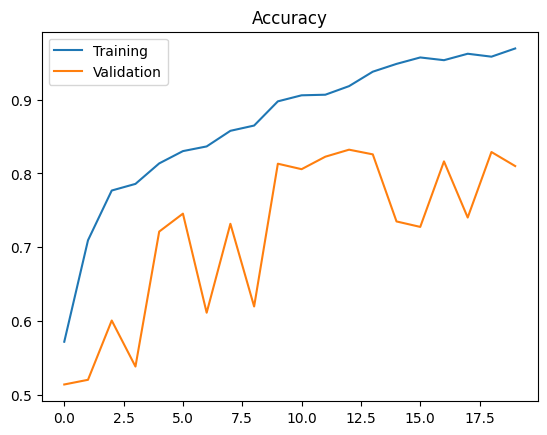

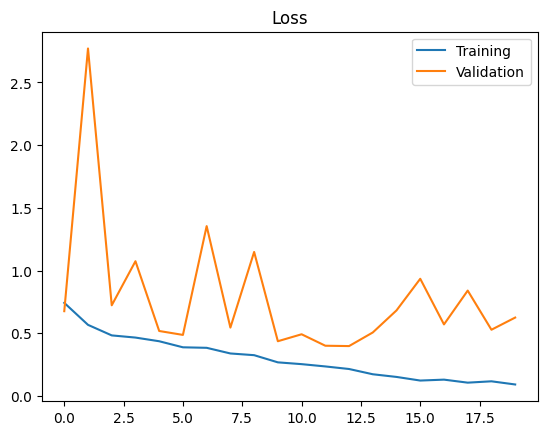

In [101]:
img_accuracy, img_loss = plot_result(model_final_tuned)

In [102]:
val_loss, val_accuracy, val_precision, val_recall = best_model.evaluate(X_validation, y_validation)

30/30 [==============================] - 1s 45ms/step - loss: 0.6256 - accuracy: 0.8099 - precision_2: 0.7819 - recall_2: 0.8370


In [103]:
print([val_accuracy, val_loss])

[0.8099260926246643, 0.625598132610321]


### CROSS-VALIDATION 5th Architecture *

In [105]:
k_fold = StratifiedKFold(5, shuffle=True)
history = []

for train_index, val_index in k_fold.split(X_train, y_train):
    X_train_fold = X_train[train_index]
    y_train_fold = y_train[train_index]
    X_validation_fold = X_train[val_index]
    y_validation_fold = y_train[val_index]

    model = hp_tuner(best_hp)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006),
                   loss = 'binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), zero_one_loss])
    history_k = model.fit(X_train_fold, y_train_fold,
                          validation_data = (X_validation_fold, y_validation_fold),
                          epochs = 20,
                          batch_size=32,
                          callbacks = early_stopping
                          )
    history.append(history_k)
    

Epoch 1/20
119/119 [==============================] - 55s 432ms/step - loss: 0.6719 - accuracy: 0.6152 - precision_4: 0.5791 - recall_4: 0.5974 - zero_one_loss: 0.3832 - val_loss: 1.1022 - val_accuracy: 0.5396 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_zero_one_loss: 0.4620
Epoch 2/20
119/119 [==============================] - 43s 363ms/step - loss: 0.5061 - accuracy: 0.7660 - precision_4: 0.7447 - recall_4: 0.7473 - zero_one_loss: 0.2338 - val_loss: 3.4786 - val_accuracy: 0.5396 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_zero_one_loss: 0.4620
Epoch 3/20
119/119 [==============================] - 41s 345ms/step - loss: 0.4566 - accuracy: 0.7969 - precision_4: 0.7832 - recall_4: 0.7720 - zero_one_loss: 0.2048 - val_loss: 1.2322 - val_accuracy: 0.5238 - val_precision_4: 0.2222 - val_recall_4: 0.0138 - val_zero_one_loss: 0.4783
Epoch 4/20
119/119 [==============================] - 43s 364ms/step - loss: 0.4280 - accuracy: 0.8098 - precision_4: 0.800

Plot CV results

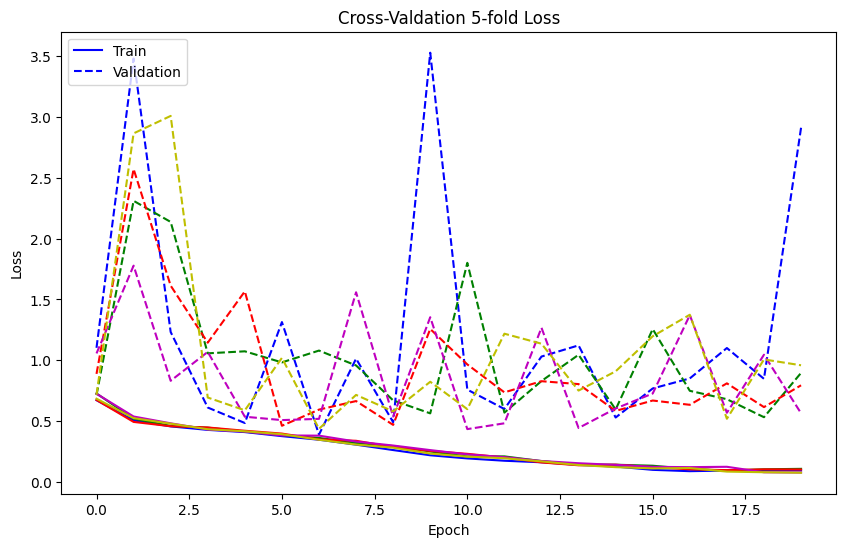

In [107]:
plot_loss(history)

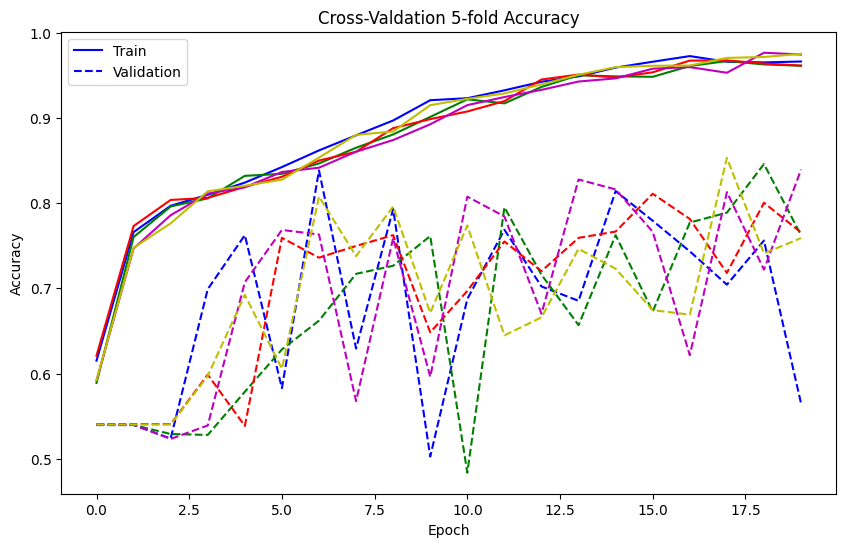

In [108]:
plot_accuracy(history)

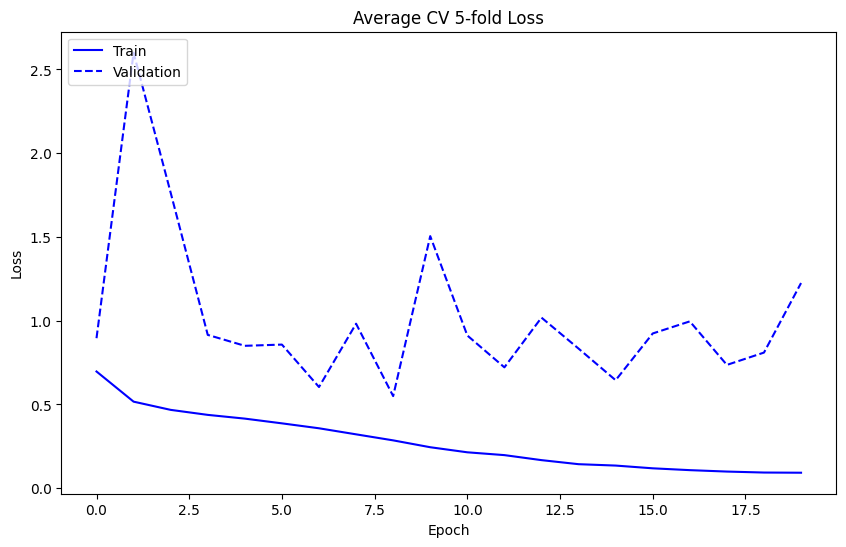

In [110]:
plot_avg_loss(history)

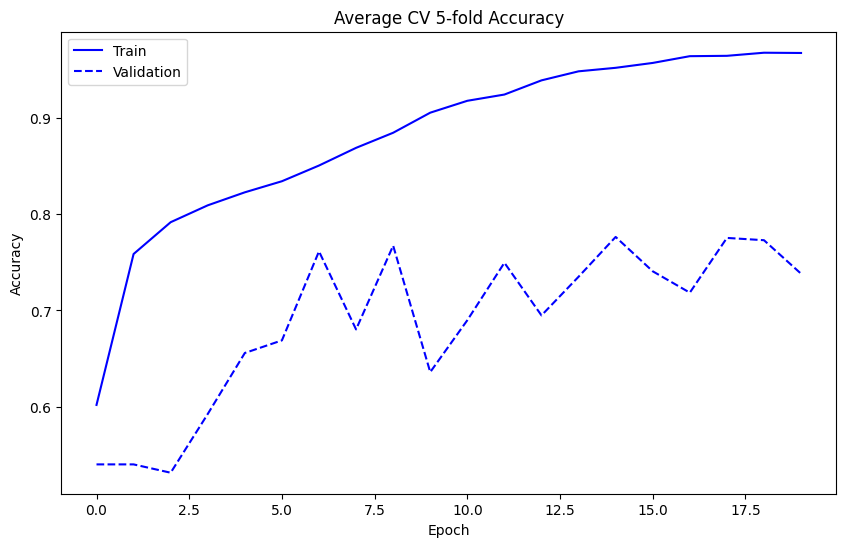

In [111]:
plot_avg_accuracy(history)

## FINAL ARCHITECTURE

In [77]:
cnn_mf_2 = Sequential()

# Convolution layers
cnn_mf_2.add(Conv2D(filters=32, kernel_size=(3, 3), strides=2, input_shape=image_shape))
cnn_mf_2.add(Activation('relu'))
cnn_mf_2.add(Dropout(0.25))

cnn_mf_2.add(Conv2D(filters=48, kernel_size=(3, 3), strides=2, padding = 'valid'))
cnn_mf_2.add(Activation('relu'))
cnn_mf_2.add(Dropout(0.25))

cnn_mf_2.add(Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding = 'valid'))
cnn_mf_2.add(Activation('relu'))
cnn_mf_2.add(Dropout(0.25))


# Dense layer
cnn_mf_2.add(Flatten())
cnn_mf_2.add(Dense(128))
cnn_mf_2.add(Activation('relu'))

cnn_mf_2.add(Dropout(0.5))

cnn_mf_2.add(Dense(1, activation='sigmoid'))


cnn_mf_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), zero_one_loss])

cnn_mf_2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 31, 31, 32)        320       
                                                                 
 activation_47 (Activation)  (None, 31, 31, 32)        0         
                                                                 
 dropout_39 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 14, 14, 64)        51264     
                                                                 
 activation_48 (Activation)  (None, 14, 14, 64)        0         
                                                                 
 dropout_40 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 flatten_17 (Flatten)        (None, 12544)           

In [78]:
model_final_2 = cnn_mf_2.fit(
    X_train_, y_train_,
    validation_data = (X_validation, y_validation),
    epochs = 20,
    batch_size = 32,
    callbacks = early_stopping
    )

Epoch 1/20
119/119 [==============================] - 15s 112ms/step - loss: 0.6883 - accuracy: 0.5425 - precision_17: 0.4950 - recall_17: 0.1738 - zero_one_loss: 0.4566 - val_loss: 0.6785 - val_accuracy: 0.5512 - val_precision_17: 0.7049 - val_recall_17: 0.0956 - val_zero_one_loss: 0.4498
Epoch 2/20
119/119 [==============================] - 13s 110ms/step - loss: 0.6634 - accuracy: 0.5877 - precision_17: 0.5880 - recall_17: 0.3192 - zero_one_loss: 0.4122 - val_loss: 0.6163 - val_accuracy: 0.6769 - val_precision_17: 0.6338 - val_recall_17: 0.7578 - val_zero_one_loss: 0.3252
Epoch 3/20
119/119 [==============================] - 14s 119ms/step - loss: 0.6079 - accuracy: 0.6638 - precision_17: 0.6265 - recall_17: 0.6501 - zero_one_loss: 0.3372 - val_loss: 0.5722 - val_accuracy: 0.7244 - val_precision_17: 0.7589 - val_recall_17: 0.6156 - val_zero_one_loss: 0.2776
Epoch 4/20
119/119 [==============================] - 12s 103ms/step - loss: 0.5485 - accuracy: 0.7314 - precision_17: 0.7079 -

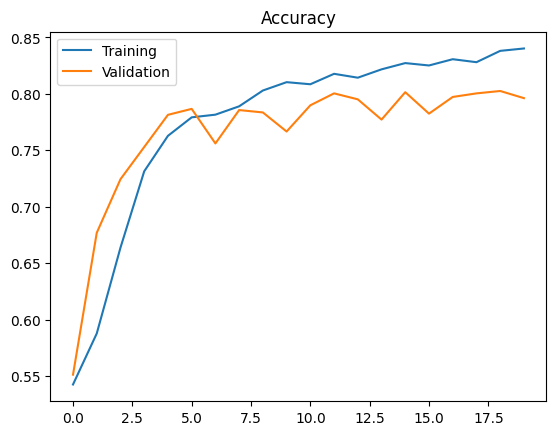

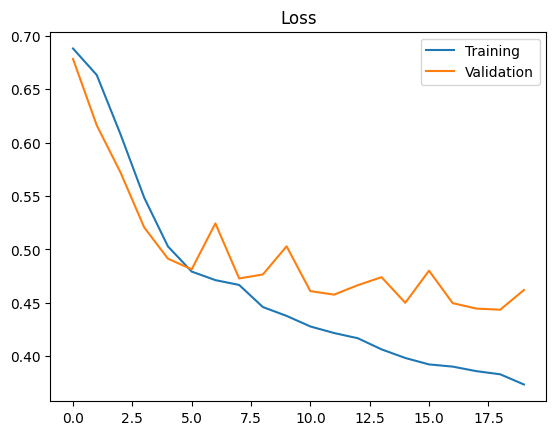

In [79]:
img_accuracy, img_loss = plot_result(model_final_2)

### trial HP tuning final arch *
We tried tuning also for the kernel size

In [125]:
def hp_tuner_2(hp):
    try:
        image_shape = (64, 64, 1)
        dropout_conv = hp.Float('dropout_conv_layer',
                                min_value = 0.1,
                                max_value = 0.3,
                                step = 0.05)
        dropout_dense = hp.Float('dropout_dense_layer',
                                min_value = 0.3,
                                max_value = 0.5,
                                step = 0.1)

        model = Sequential()

        # Conv 1
        model.add(Conv2D(filters = hp.Int('conv_1_filters',
                                        min_value = 16,
                                        max_value = 128,
                                        step = 16),
                                        kernel_size = hp.Int(
                                            'conv_1_kernel_size',
                                            min_value = 3,
                                            max_value = 5,
                                            step = 2),
                                        strides = 2,
                                        input_shape = image_shape))
        model.add(Activation('relu'))
        model.add(Dropout(dropout_conv))


        # Conv 2
        model.add(Conv2D(filters = hp.Int('conv_2_filters',
                                        min_value = 16,
                                        max_value = 128,
                                        step = 16),
                                        kernel_size = hp.Int(
                                            'conv_2_kernel_size',
                                            min_value = 3,
                                            max_value = 5,
                                            step = 2),
                                        strides = 2,
                                        padding = 'valid'))
        model.add(Activation('relu'))
        model.add(Dropout(dropout_conv))

        # Conv 3
        model.add(Conv2D(filters = hp.Int('conv_3_filters',
                                        min_value = 16,
                                        max_value = 128,
                                        step = 16),
                                        kernel_size = hp.Int(
                                            'conv_3_kernel_size',
                                            min_value = 3,
                                            max_value = 5,
                                            step = 2),
                                        strides = 2,
                                        padding = 'valid'))
        model.add(Activation('relu'))
        model.add(Dropout(dropout_conv))



        # Dense 
        model.add(Flatten())
        model.add(Dense(units = hp.Int('dense_units',
                                    min_value = 32,
                                    max_value = 256,
                                    step = 32)))
        model.add(Activation('relu'))

        model.add(Dropout(dropout_dense))



        # Output
        model.add(Dense(1, activation = 'sigmoid'))
        
        # Compile
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss = 'binary_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall()])
        
        return model
    
    except:
        # dummy model so the tuner won't break
        dummy_model = Sequential()
        dummy_model.add(Dense(1, input_shape=(1,)))
        dummy_model.compile(optimizer = tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
        return dummy_model


In [126]:
# tuner
tuner_2 = BayesianOptimization(
    hypermodel=hp_tuner_2,
    objective='val_loss',
    max_trials=30,
    directory = 'tuning',
    project_name= 'hp_final_tuned'
)


Reloading Tuner from tuning\hp_final_tuned\tuner0.json


In [127]:
tuner_2.search_space_summary()

Search space summary
Default search space size: 9
dropout_conv_layer (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.05, 'sampling': 'linear'}
dropout_dense_layer (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
conv_1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
conv_1_kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': 'linear'}
conv_2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
conv_2_kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': 'linear'}
conv_3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
conv_3_kernel_size (Int)
{'default': None, 'conditio

In [128]:
# tuning activation
tuner_2.search(
    X_train, 
    y_train,
    epochs=20,
    validation_data=[X_validation, y_validation],
    batch_size=32
)

Trial 30 Complete [00h 16m 10s]
val_loss: 0.051352400332689285

Best val_loss So Far: 0.051352400332689285
Total elapsed time: 04h 42m 20s


In [129]:
best_hp_2 = tuner_2.get_best_hyperparameters(1)[0]

In [130]:
tune_results_2 = tuner_2.results_summary()
tune_results_2

Results summary
Results in tuning\hp_final_tuned
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 29 summary
Hyperparameters:
dropout_conv_layer: 0.1
dropout_dense_layer: 0.4
conv_1_filters: 128
conv_1_kernel_size: 5
conv_2_filters: 128
conv_2_kernel_size: 5
conv_3_filters: 128
conv_3_kernel_size: 5
dense_units: 256
Score: 0.051352400332689285

Trial 27 summary
Hyperparameters:
dropout_conv_layer: 0.1
dropout_dense_layer: 0.4
conv_1_filters: 128
conv_1_kernel_size: 5
conv_2_filters: 128
conv_2_kernel_size: 5
conv_3_filters: 128
conv_3_kernel_size: 5
dense_units: 256
Score: 0.05515235662460327

Trial 28 summary
Hyperparameters:
dropout_conv_layer: 0.1
dropout_dense_layer: 0.5
conv_1_filters: 128
conv_1_kernel_size: 5
conv_2_filters: 128
conv_2_kernel_size: 5
conv_3_filters: 128
conv_3_kernel_size: 5
dense_units: 256
Score: 0.06137445941567421

Trial 01 summary
Hyperparameters:
dropout_conv_layer: 0.2
dropout_dense_layer: 0.4
conv_1_filters: 128
conv_1_kernel_siz

BEST MODEL tuning also Kernel size* <br> 
(BEST TRIAL FROM THE TUNER) <br>
In the end we tried other best hyperparameters since there seem to be extreme overfitting

In [131]:
best_model = hp_tuner_2(best_hp_2)

In [132]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 128)       3328      
                                                                 
 activation_4 (Activation)   (None, 30, 30, 128)       0         
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 128)       409728    


                                                                 
 activation_5 (Activation)   (None, 13, 13, 128)       0         
                                                                 
 dropout_5 (Dropout)         (None, 13, 13, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 128)         409728    
                                                                 
 activation_6 (Activation)   (None, 5, 5, 128)         0         
                                                                 
 dropout_6 (Dropout)         (None, 5, 5, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               819456    
                                                                 
 activatio

In [133]:
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss = 'binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), zero_one_loss])

In [134]:
model_final_tuned_2 = best_model.fit(
    X_train_, y_train_,
    validation_data = (X_validation, y_validation),
    epochs = 20,
    batch_size = 32,
    callbacks = early_stopping
)

Epoch 1/20
119/119 [==============================] - 50s 403ms/step - loss: 0.6708 - accuracy: 0.5750 - precision_2: 0.6021 - recall_2: 0.1999 - zero_one_loss: 0.4254 - val_loss: 0.6335 - val_accuracy: 0.6199 - val_precision_2: 0.5602 - val_recall_2: 0.9311 - val_zero_one_loss: 0.3800
Epoch 2/20
119/119 [==============================] - 39s 331ms/step - loss: 0.5603 - accuracy: 0.7153 - precision_2: 0.6759 - recall_2: 0.7213 - zero_one_loss: 0.2842 - val_loss: 0.5016 - val_accuracy: 0.7677 - val_precision_2: 0.7875 - val_recall_2: 0.7000 - val_zero_one_loss: 0.2342
Epoch 3/20
119/119 [==============================] - 40s 340ms/step - loss: 0.4971 - accuracy: 0.7639 - precision_2: 0.7383 - recall_2: 0.7468 - zero_one_loss: 0.2365 - val_loss: 0.5265 - val_accuracy: 0.7476 - val_precision_2: 0.6791 - val_recall_2: 0.8889 - val_zero_one_loss: 0.2532
Epoch 4/20
119/119 [==============================] - 38s 319ms/step - loss: 0.4739 - accuracy: 0.7824 - precision_2: 0.7598 - recall_2: 0.

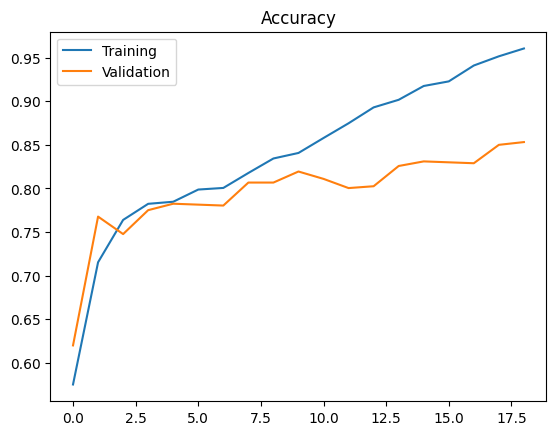

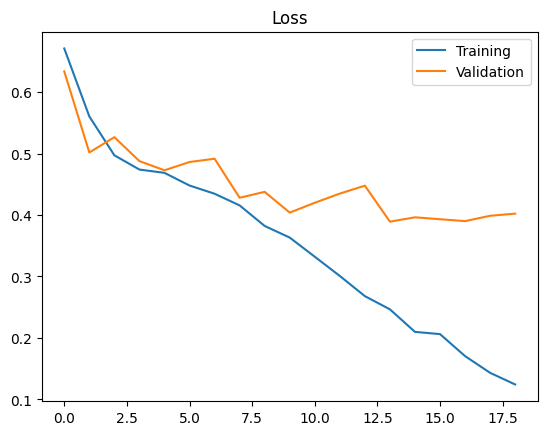

In [135]:
img_accuracy, img_loss = plot_result(model_final_tuned_2)

BEST MODEL tuning also kernel size * <br>
(FOURTH BEST OPTION from tuner) <br>
We tried this as best model since it was the first model without all Conv layers with kernel size = 5 

In [143]:
best_hp_2 = tuner_2.get_best_hyperparameters(4)[3]

In [144]:
best_model = hp_tuner_2(best_hp_2)
best_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 31, 31, 128)       1280      
                                                                 
 activation_16 (Activation)  (None, 31, 31, 128)       0         
                                                                 
 dropout_16 (Dropout)        (None, 31, 31, 128)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 activation_17 (Activation)  (None, 14, 14, 128)       0         
                                                                 
 dropout_17 (Dropout)        (None, 14, 14, 128)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 5, 5, 112)        

In [145]:
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss = 'binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), zero_one_loss])

In [146]:
model_final_tuned_2 = best_model.fit(
    X_train_, y_train_,
    validation_data = (X_validation, y_validation),
    epochs = 20,
    batch_size = 32,
    callbacks = early_stopping
)

Epoch 1/20
119/119 [==============================] - 58s 462ms/step - loss: 0.6847 - accuracy: 0.5415 - precision_6: 0.4865 - recall_6: 0.1043 - zero_one_loss: 0.4576 - val_loss: 0.6802 - val_accuracy: 0.6135 - val_precision_6: 0.5580 - val_recall_6: 0.8978 - val_zero_one_loss: 0.3870
Epoch 2/20
119/119 [==============================] - 49s 413ms/step - loss: 0.6507 - accuracy: 0.6041 - precision_6: 0.5854 - recall_6: 0.4508 - zero_one_loss: 0.3948 - val_loss: 0.5967 - val_accuracy: 0.6980 - val_precision_6: 0.7147 - val_recall_6: 0.6067 - val_zero_one_loss: 0.3043
Epoch 3/20
119/119 [==============================] - 49s 407ms/step - loss: 0.5812 - accuracy: 0.6973 - precision_6: 0.6588 - recall_6: 0.6970 - zero_one_loss: 0.3027 - val_loss: 0.5682 - val_accuracy: 0.7117 - val_precision_6: 0.6347 - val_recall_6: 0.9267 - val_zero_one_loss: 0.2894
Epoch 4/20
119/119 [==============================] - 45s 376ms/step - loss: 0.5174 - accuracy: 0.7517 - precision_6: 0.7314 - recall_6: 0.

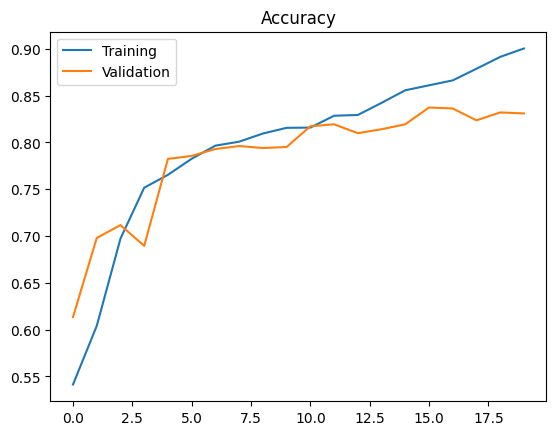

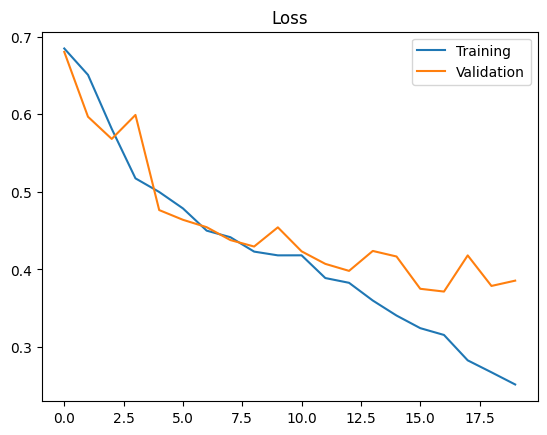

In [147]:
img_accuracy, img_loss = plot_result(model_final_tuned_2)

### HP TUNING FINAL ARCHITECTURE
We decided to not tune the kernel size since the tuner results were mostly assigning all kernel to be size 5

In [148]:
def hp_tuner_1(hp):

    image_shape = (64, 64, 1)
    dropout_conv = hp.Float('dropout_conv_layer',
                            min_value = 0.1,
                            max_value = 0.3,
                            step = 0.05)
    dropout_dense = hp.Float('dropout_dense_layer',
                            min_value = 0.3,
                            max_value = 0.5,
                            step = 0.1)

    model = Sequential()

    # Conv 1
    model.add(Conv2D(filters = hp.Int('conv_1_filters',
                                    min_value = 16,
                                    max_value = 64,
                                    step = 16),
                                    kernel_size = (3,3),
                                    strides = 2,
                                    input_shape = image_shape))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_conv))


    # Conv 2
    model.add(Conv2D(filters = hp.Int('conv_2_filters',
                                    min_value = 16,
                                    max_value = 96,
                                    step = 16),
                                    kernel_size = (3,3),
                                    strides = 2,
                                    padding = 'valid'))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_conv))

    # Conv 3
    model.add(Conv2D(filters = hp.Int('conv_3_filters',
                                    min_value = 16,
                                    max_value = 128,
                                    step = 16),
                                    kernel_size = (3,3),
                                    strides = 2,
                                    padding = 'valid'))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_conv))



    # Dense 
    model.add(Flatten())
    model.add(Dense(units = hp.Int('dense_units',
                                min_value = 32,
                                max_value = 256,
                                step = 32)))
    model.add(Activation('relu'))

    model.add(Dropout(dropout_dense))



    # Output
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Compile
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss = 'binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()])
    
    return model


In [149]:
# tuner
tuner_1 = BayesianOptimization(
    hypermodel=hp_tuner_1,
    objective='val_loss',
    max_trials=30,
    directory = 'tuning',
    project_name= 'hp_final_tuned_1'
)

In [150]:
tuner_1.search_space_summary()

Search space summary
Default search space size: 6
dropout_conv_layer (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.05, 'sampling': 'linear'}
dropout_dense_layer (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
conv_1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
conv_2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 96, 'step': 16, 'sampling': 'linear'}
conv_3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}


In [151]:
# tuning activation
tuner_1.search(
    X_train, 
    y_train,
    epochs=20,
    validation_data=[X_validation, y_validation],
    batch_size=32
)

Trial 30 Complete [00h 07m 14s]
val_loss: 0.2807750701904297

Best val_loss So Far: 0.27000343799591064
Total elapsed time: 02h 44m 51s


In [152]:
tune_results_1 = tuner_1.results_summary()
tune_results_1

Results summary
Results in tuning\hp_final_tuned_1
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 24 summary
Hyperparameters:
dropout_conv_layer: 0.1
dropout_dense_layer: 0.5
conv_1_filters: 64
conv_2_filters: 96
conv_3_filters: 128
dense_units: 256
Score: 0.27000343799591064

Trial 29 summary
Hyperparameters:
dropout_conv_layer: 0.1
dropout_dense_layer: 0.5
conv_1_filters: 64
conv_2_filters: 96
conv_3_filters: 128
dense_units: 256
Score: 0.2807750701904297

Trial 26 summary
Hyperparameters:
dropout_conv_layer: 0.1
dropout_dense_layer: 0.5
conv_1_filters: 64
conv_2_filters: 96
conv_3_filters: 128
dense_units: 256
Score: 0.2814595401287079

Trial 05 summary
Hyperparameters:
dropout_conv_layer: 0.1
dropout_dense_layer: 0.5
conv_1_filters: 64
conv_2_filters: 96
conv_3_filters: 128
dense_units: 256
Score: 0.2826765477657318

Trial 19 summary
Hyperparameters:
dropout_conv_layer: 0.1
dropout_dense_layer: 0.4
conv_1_filters: 64
conv_2_filters: 96
conv_3_filters: 80


In [153]:
best_hp_1 = tuner_1.get_best_hyperparameters(1)[0]

In [154]:
best_model = hp_tuner_1(best_hp_1)

In [155]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 31, 31, 64)        640       
                                                                 
 activation_4 (Activation)   (None, 31, 31, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 31, 31, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 15, 15, 96)        55392     
                                                                 
 activation_5 (Activation)   (None, 15, 15, 96)        0         
                                                                 
 dropout_5 (Dropout)         (None, 15, 15, 96)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)        

In [156]:
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss = 'binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), zero_one_loss])

In [157]:
model_final_tuned_1 = best_model.fit(
    X_train_, y_train_,
    validation_data = (X_validation, y_validation),
    epochs = 20,
    batch_size = 32,
    callbacks = early_stopping
)

Epoch 1/20
119/119 [==============================] - 19s 143ms/step - loss: 0.6829 - accuracy: 0.5465 - precision_2: 0.5231 - recall_2: 0.0591 - zero_one_loss: 0.4526 - val_loss: 0.6774 - val_accuracy: 0.5280 - val_precision_2: 0.5789 - val_recall_2: 0.0244 - val_zero_one_loss: 0.4735
Epoch 2/20
119/119 [==============================] - 17s 139ms/step - loss: 0.6385 - accuracy: 0.6360 - precision_2: 0.6207 - recall_2: 0.5185 - zero_one_loss: 0.3630 - val_loss: 0.5832 - val_accuracy: 0.7033 - val_precision_2: 0.7107 - val_recall_2: 0.6333 - val_zero_one_loss: 0.2991
Epoch 3/20
119/119 [==============================] - 16s 133ms/step - loss: 0.5596 - accuracy: 0.7213 - precision_2: 0.6857 - recall_2: 0.7178 - zero_one_loss: 0.2788 - val_loss: 0.5230 - val_accuracy: 0.7582 - val_precision_2: 0.7326 - val_recall_2: 0.7733 - val_zero_one_loss: 0.2442
Epoch 4/20
119/119 [==============================] - 16s 135ms/step - loss: 0.5042 - accuracy: 0.7652 - precision_2: 0.7455 - recall_2: 0.

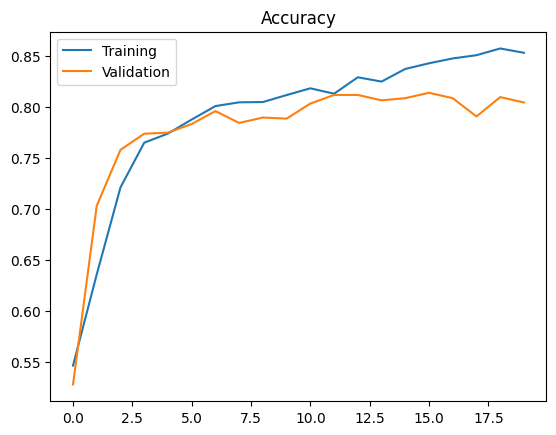

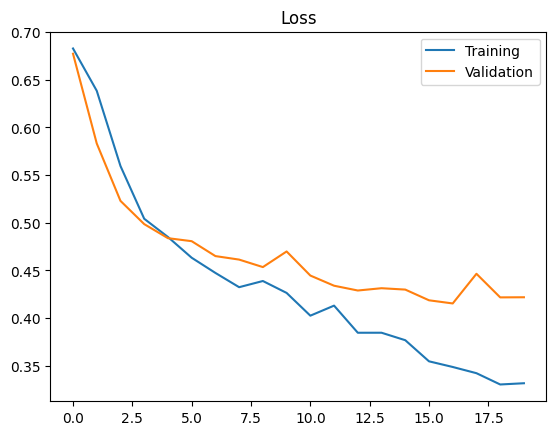

In [172]:
img_accuracy, img_loss = plot_result(model_final_tuned_1)

In [173]:
# save_plots_as_jpeg([img_accuracy, img_loss], save_directory)

### CROSS-VALIDATION 5-FOLD

In [159]:
k_fold = StratifiedKFold(5, shuffle=True)
history = []

for train_index, val_index in k_fold.split(X_train, y_train):
    X_train_fold = X_train[train_index]
    y_train_fold = y_train[train_index]
    X_validation_fold = X_train[val_index]
    y_validation_fold = y_train[val_index]

    # model = hp_tuner_2(best_hp_2)
    model = hp_tuner_1(best_hp_1)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss = 'binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), zero_one_loss])
    history_k = model.fit(X_train_fold, y_train_fold,
                          validation_data = (X_validation_fold, y_validation_fold),
                          epochs = 20,
                          batch_size=32,
                          callbacks = early_stopping
                          )
    history.append(history_k)

Epoch 1/20
119/119 [==============================] - 18s 136ms/step - loss: 0.6837 - accuracy: 0.5460 - precision_4: 0.5178 - recall_4: 0.1753 - zero_one_loss: 0.4543 - val_loss: 0.6719 - val_accuracy: 0.5607 - val_precision_4: 0.6316 - val_recall_4: 0.1101 - val_zero_one_loss: 0.4390
Epoch 2/20
119/119 [==============================] - 16s 132ms/step - loss: 0.6575 - accuracy: 0.6083 - precision_4: 0.6040 - recall_4: 0.4287 - zero_one_loss: 0.3918 - val_loss: 0.6186 - val_accuracy: 0.6420 - val_precision_4: 0.6280 - val_recall_4: 0.5459 - val_zero_one_loss: 0.3588
Epoch 3/20
119/119 [==============================] - 16s 135ms/step - loss: 0.6020 - accuracy: 0.6690 - precision_4: 0.6321 - recall_4: 0.6695 - zero_one_loss: 0.3302 - val_loss: 0.5617 - val_accuracy: 0.7128 - val_precision_4: 0.6667 - val_recall_4: 0.7523 - val_zero_one_loss: 0.2883
Epoch 4/20
119/119 [==============================] - 16s 132ms/step - loss: 0.5411 - accuracy: 0.7385 - precision_4: 0.7102 - recall_4: 0.

5-FOLD CV RESULTS

In [177]:
cv_val_loss = []
cv_val_accuracy = []
cv_val_zero_one_loss = []
cv_train_loss = []
cv_train_accuracy = []
cv_train_zero_one_loss = []

for history_k in history:
    cv_val_loss.append(history_k.history['val_loss'][-1])
    cv_val_accuracy.append(history_k.history['val_accuracy'][-1])
    cv_val_zero_one_loss.append(history_k.history['val_zero_one_loss'][-1])
    cv_train_loss.append(history_k.history['loss'][-1])
    cv_train_accuracy.append(history_k.history['accuracy'][-1])
    cv_train_zero_one_loss.append(history_k.history['zero_one_loss'][-1])

print("avg val loss: ", np.mean(cv_val_loss))
print("avg val accuracy: ", np.mean(cv_val_accuracy))
print("avg val zero-one loss: ", np.mean(cv_val_zero_one_loss))
print("avg train loss: ", np.mean(cv_train_loss))
print("avg train accuracy: ", np.mean(cv_train_accuracy))
print("avg train zero-one loss: ", np.mean(cv_train_zero_one_loss))


avg val loss:  0.406261545419693
avg val accuracy:  0.812384057044983
avg val zero-one loss:  0.1871125727891922
avg train loss:  0.3186058223247528
avg train accuracy:  0.8659937143325805
avg train zero-one loss:  0.13390852361917496


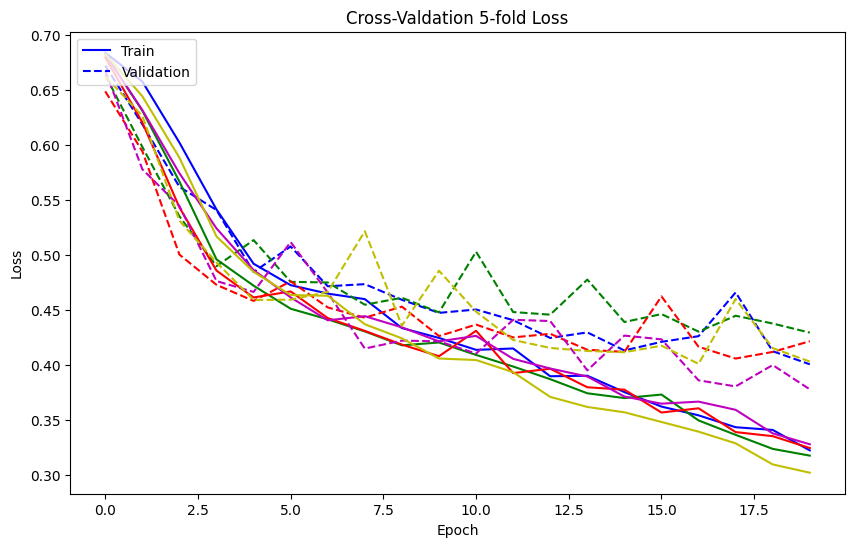

In [160]:
plot_loss(history)

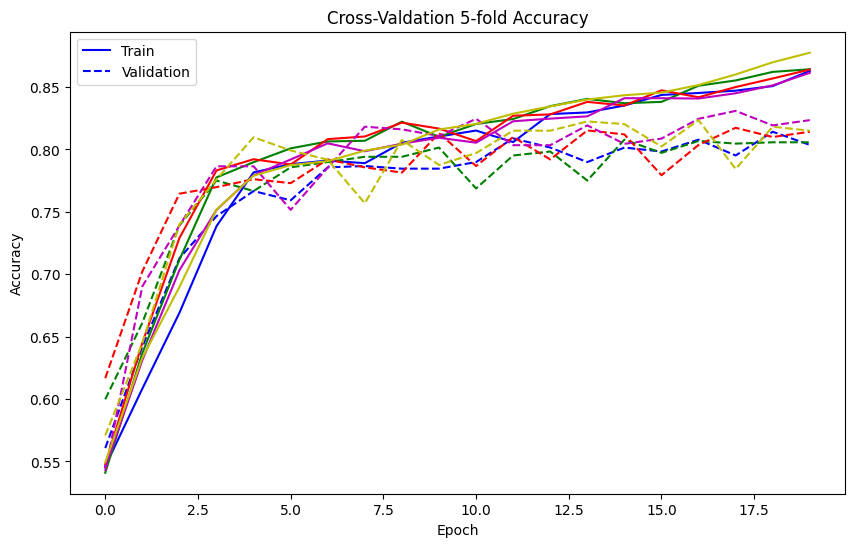

In [161]:
plot_accuracy(history)

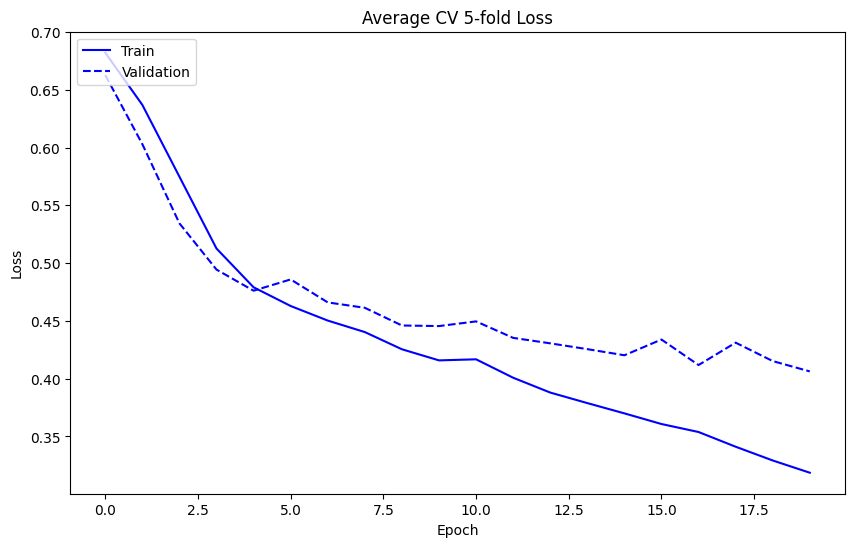

In [162]:
plot_avg_loss(history)

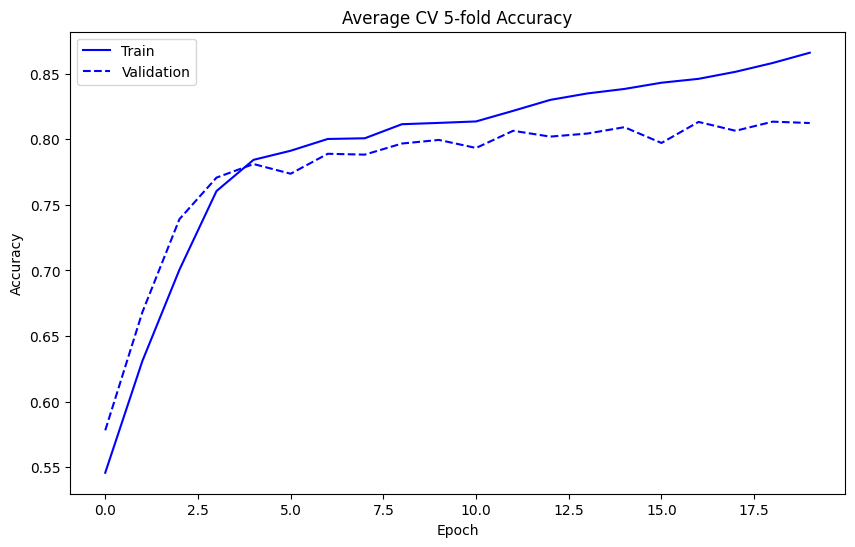

In [163]:
plot_avg_accuracy(history)

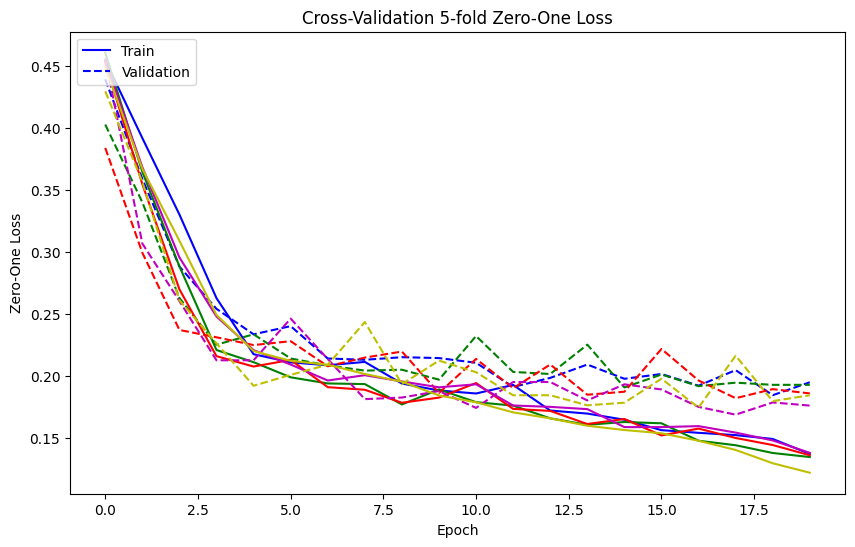

In [166]:
plot_zero_one_loss(history)

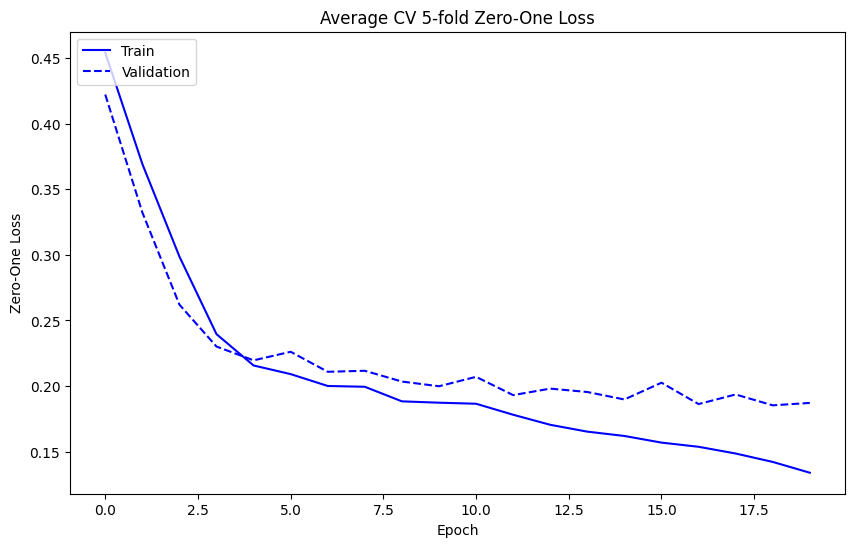

In [167]:
plot_avg_zero_one_loss(history)

### PREDICTION with test set

In [168]:
test_loss, test_accuracy, test_precision, test_recall, test_zero_one_loss = best_model.evaluate(X_test, y_test)

37/37 [==============================] - 1s 25ms/step - loss: 0.4212 - accuracy: 0.8074 - precision_2: 0.7446 - recall_2: 0.8842 - zero_one_loss: 0.1926


In [169]:
print(f"test loss = {test_loss}\n test_accuracy = {test_accuracy}\n test zero-one loss = {test_zero_one_loss}")

test loss = 0.42116445302963257
 test_accuracy = 0.8074324131011963
 test zero-one loss = 0.19256757199764252


In [170]:
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
results = classification_report(y_test, y_pred)
print(results)

37/37 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

         0.0       0.88      0.74      0.81       640
         1.0       0.74      0.88      0.81       544

    accuracy                           0.81      1184
   macro avg       0.81      0.81      0.81      1184
weighted avg       0.82      0.81      0.81      1184



In [171]:
results_matrix = confusion_matrix(y_test, y_pred)
results_matrix

array([[475, 165],
       [ 63, 481]], dtype=int64)